In [207]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
import scipy.stats as stats
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor
from pandas import DataFrame


In [208]:
import numpy as np
from pandas import DataFrame, MultiIndex, concat, DatetimeIndex, Series
from math import sqrt
from scipy.stats import t, pearsonr, spearmanr
from sklearn.impute import SimpleImputer
from scipy.stats import shapiro, normaltest, ks_2samp, bartlett, fligner, levene, chi2_contingency
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from pca import pca
from statsmodels.formula.api import logit
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, accuracy_score, recall_score, precision_score, f1_score

from matplotlib import pyplot as plt
import seaborn as sb
import sys

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from tabulate import tabulate

In [209]:
plt.rcParams["font.family"] = 'AppleGothic' if sys.platform == 'darwin' else 'Malgun Gothic'
plt.rcParams["font.size"] = 12
plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["axes.unicode_minus"] = False

In [210]:
df = pd.read_excel("빚추가마지막.xlsx")
df.head()

,Unnamed: 0,gen,age,religion,edu,sm_year,sm_state,sm_day,dr_mean_year,dr_6cup,...,preg_experience,health_state,disabled,work_state,work_code,region,income,y_total,debt,y_train
0,0,female,78,yes,중졸,NaN,no,NaN,전혀마시지않음,NaN,...,없다,2,abled,nowork,NaN,city,405.0,20,10350.0,0
1,1,male,75,no,초졸이하,NaN,no,NaN,전혀마시지않음,NaN,...,남성,1,abled,work,942.0,city,2788.0,29,0.0,1
2,2,male,81,yes,대졸이상,NaN,no,NaN,전혀마시지않음,NaN,...,남성,4,abled,work,762.0,city,2304.0,18,21220.0,0
3,3,male,61,yes,대졸이상,NaN,no,NaN,전혀마시지않음,NaN,...,남성,4,abled,work,855.0,city,5231.0,20,0.0,0
4,4,female,60,yes,고졸,NaN,no,NaN,전혀마시지않음,NaN,...,없다,4,abled,work,399.0,city,5231.0,21,0.0,0


### 맨 먼저 해야하는 건 다른 변수 들 중 소득 및 빚에 따른 우울감 차이를 볼거기 떄문에 소득과 빚이 있는 사람들로 기준을 잡아서 데이터를 전처리 및 분석할 것임

In [211]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13474 entries, 0 to 13473
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       13474 non-null  int64  
 1   gen              13474 non-null  object 
 2   age              13474 non-null  int64  
 3   religion         13474 non-null  object 
 4   edu              13474 non-null  object 
 5   sm_year          1119 non-null   float64
 6   sm_state         13474 non-null  object 
 7   sm_day           2036 non-null   float64
 8   dr_mean_year     13474 non-null  object 
 9   dr_6cup          5711 non-null   object 
 10  dr_hurt          5711 non-null   object 
 11  dr_worry         5711 non-null   object 
 12  preg_experience  13474 non-null  object 
 13  health_state     13474 non-null  int64  
 14  disabled         13474 non-null  object 
 15  work_state       13474 non-null  object 
 16  work_code        8058 non-null   float64
 17  region      

In [212]:
df= df.loc[(df['income']>0)&(df['debt']>0),:]
df = df.iloc[:,1:]

In [213]:
df

,gen,age,religion,edu,sm_year,sm_state,sm_day,dr_mean_year,dr_6cup,dr_hurt,...,preg_experience,health_state,disabled,work_state,work_code,region,income,y_total,debt,y_train
0,female,78,yes,중졸,NaN,no,NaN,전혀마시지않음,NaN,NaN,...,없다,2,abled,nowork,NaN,city,405.0,20,10350.0,0
2,male,81,yes,대졸이상,NaN,no,NaN,전혀마시지않음,NaN,NaN,...,남성,4,abled,work,762.0,city,2304.0,18,21220.0,0
8,female,53,yes,고졸,NaN,no,NaN,전혀마시지않음,NaN,NaN,...,없다,2,abled,work,151.0,city,2290.8,21,1020.0,0
9,female,31,no,중졸,NaN,no,NaN,전혀마시지않음,NaN,NaN,...,없다,2,abled,nowork,NaN,city,2290.8,17,1020.0,0
13,male,45,no,대졸이상,NaN,yes,14.0,월2~3회,연1회,전혀,...,남성,4,abled,work,399.0,city,5958.0,20,12921.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13469,male,47,no,대졸이상,25.0,yes,10.0,주2~3회,주1회,전혀,...,남성,4,abled,work,151.0,city,8548.0,17,26014.0,0
13470,female,46,no,대졸이상,NaN,no,NaN,주2~3회,연1회,전혀,...,없다,4,abled,nowork,NaN,city,8548.0,17,26014.0,0
13471,male,48,no,대졸이상,25.0,yes,7.0,전혀마시지않음,NaN,NaN,...,남성,4,abled,work,222.0,city,8452.0,17,12360.0,0
13472,male,59,yes,대졸이상,32.0,no,NaN,전혀마시지않음,NaN,NaN,...,남성,4,abled,work,248.0,city,7094.0,18,1902.0,0


In [403]:
import numpy as np
from scipy import stats

# 예제 데이터 생성
data = df['y_total']

# 신뢰 수준 설정 (95%)
confidence_level = 0.94

# 데이터의 평균과 표준편차 계산
mean = np.mean(data)
std_dev = np.std(data, ddof=1)  # ddof=1 for sample standard deviation

# 신뢰구간 계산
confidence_interval = stats.t.interval(confidence_level, len(data) - 1, loc=mean, scale=std_dev/np.sqrt(len(data)))

print("Confidence Interval:", confidence_interval)

Confidence Interval: (19.009313330070047, 19.113738473403313)


In [401]:
df['y_total'].describe()

count    13474.000000
mean        19.061526
std          3.222149
min         11.000000
25%         17.000000
50%         18.000000
75%         20.000000
max         42.000000
Name: y_total, dtype: float64

## 데이터 확인 
### 연속형 변수들의 데이터 확인 및 전처리

In [215]:
df.describe()

,age,sm_year,sm_day,health_state,work_code,income,y_total,debt,y_train
count,5414.000000,383.000000,1048.000000,5414.000000,3801.000000,5414.000000,5414.000000,5414.000000,5414.000000
mean,51.013668,24.856397,14.953244,3.648134,546.257564,6628.044847,18.580901,10158.879405,0.095308
std,16.726448,14.922584,7.538168,0.861421,270.564329,3995.165853,2.982555,13604.478757,0.293668
min,17.000000,0.000000,1.000000,1.000000,111.000000,1.000000,11.000000,3.000000,0.000000
25%,39.000000,11.500000,10.000000,3.000000,312.000000,3851.500000,17.000000,2096.000000,0.000000
50%,50.000000,25.000000,15.000000,4.000000,510.000000,6113.500000,17.000000,6200.000000,0.000000
75%,63.000000,35.000000,20.000000,4.000000,842.000000,8556.000000,19.000000,13000.000000,0.000000
max,101.000000,68.000000,50.000000,5.000000,1009.000000,65676.000000,38.000000,256400.000000,1.000000


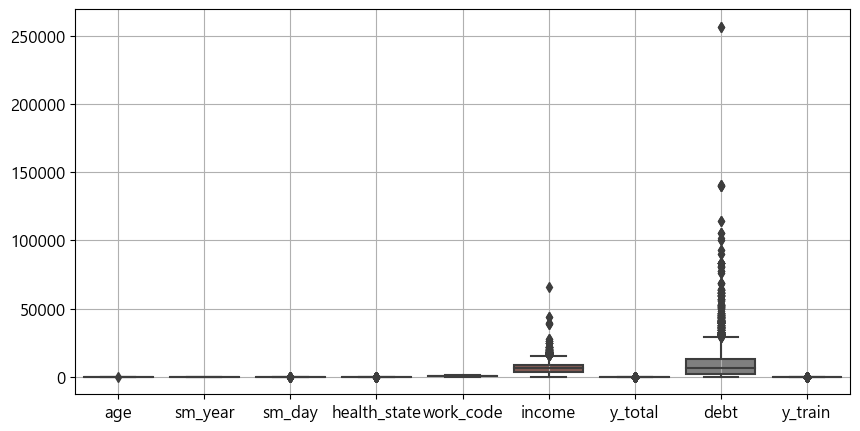

In [216]:
plt.figure(figsize=(10, 5))
sb.boxplot(data=df)
plt.grid()
plt.show()
plt.close()

<Axes: xlabel='sm_day', ylabel='y_total'>

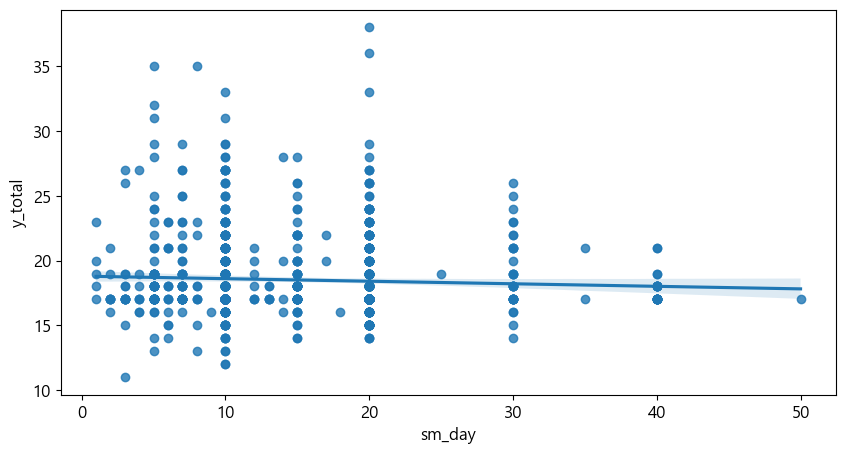

In [217]:
sns.regplot(data=df,x='sm_day',y='y_total')

<Axes: xlabel='sm_year', ylabel='y_total'>

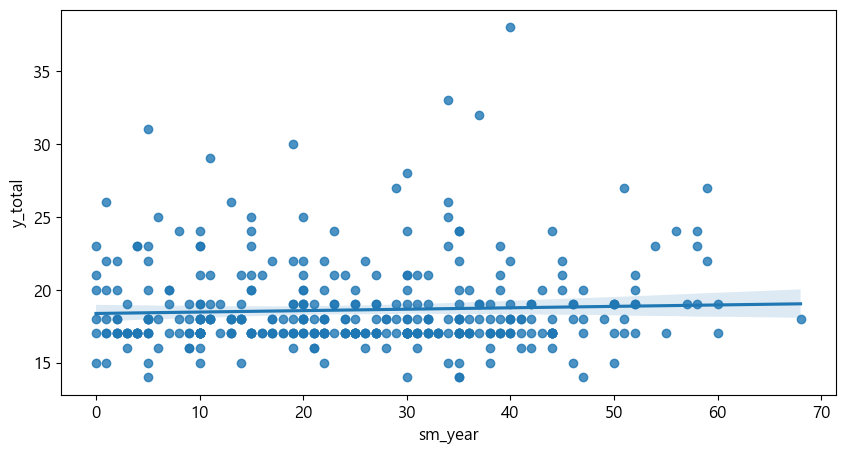

In [218]:
sns.regplot(data=df,x='sm_year',y='y_total')

<Axes: xlabel='income', ylabel='y_total'>

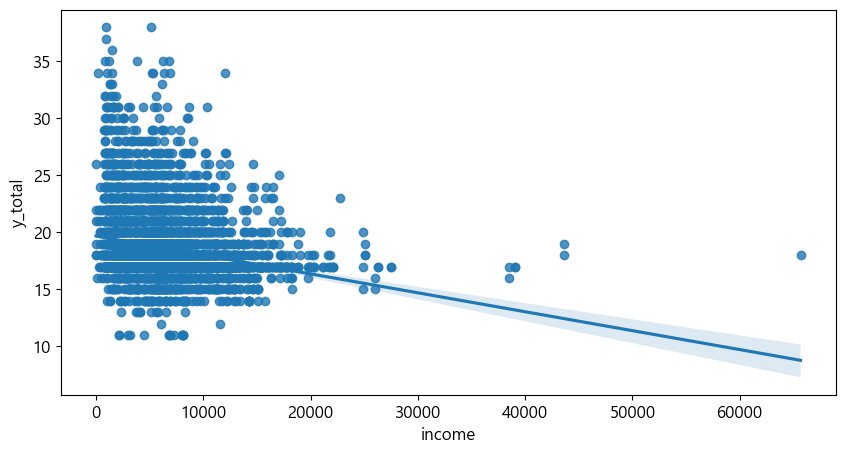

In [219]:
sns.regplot(data=df,x='income',y='y_total')

<Axes: xlabel='debt', ylabel='y_total'>

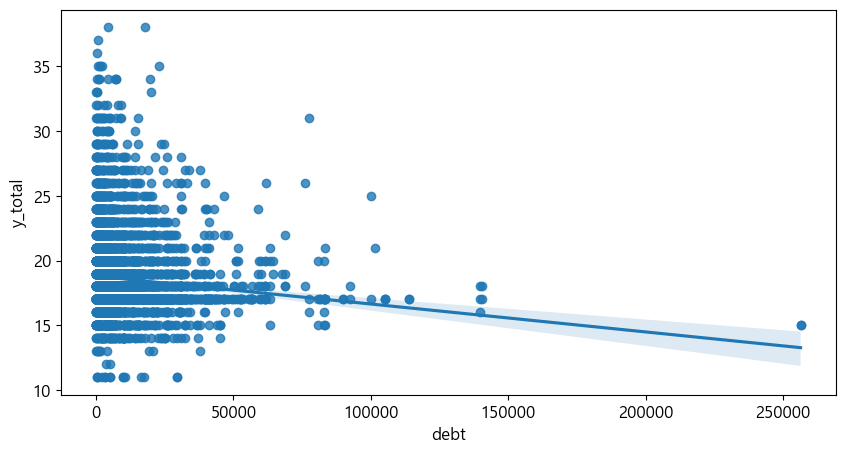

In [220]:
sns.regplot(data=df,x='debt',y='y_total')

In [221]:
## 시각화를 진행 한 결과, income이랑 debt가 상관성이 있어보여서 상관분석 진행함.

In [222]:
corr  = df[['income', 'debt' ,'y_total']].corr()
corr

,income,debt,y_total
income,1.000000,0.300693,-0.222360
debt,0.300693,1.000000,-0.098187
y_total,-0.222360,-0.098187,1.000000


In [223]:
## 근데 income과 debt의 단위는 같지만 기초통계량을 확인해 본 결과 스케일 차이가 나는거 같아서 로그변환 진행

In [224]:
df['income'] = np.log1p(df['income'])
df['debt'] = np.log1p(df['debt'])

df.head()

,gen,age,religion,edu,sm_year,sm_state,sm_day,dr_mean_year,dr_6cup,dr_hurt,...,preg_experience,health_state,disabled,work_state,work_code,region,income,y_total,debt,y_train
0,female,78,yes,중졸,NaN,no,NaN,전혀마시지않음,NaN,NaN,...,없다,2,abled,nowork,NaN,city,6.006353,20,9.244838,0
2,male,81,yes,대졸이상,NaN,no,NaN,전혀마시지않음,NaN,NaN,...,남성,4,abled,work,762.0,city,7.742836,18,9.962747,0
8,female,53,yes,고졸,NaN,no,NaN,전혀마시지않음,NaN,NaN,...,없다,2,abled,work,151.0,city,7.737093,21,6.928538,0
9,female,31,no,중졸,NaN,no,NaN,전혀마시지않음,NaN,NaN,...,없다,2,abled,nowork,NaN,city,7.737093,17,6.928538,0
13,male,45,no,대졸이상,NaN,yes,14.0,월2~3회,연1회,전혀,...,남성,4,abled,work,399.0,city,8.692658,20,9.466687,0


#### 연속형 변수의 데이터 분포 확인

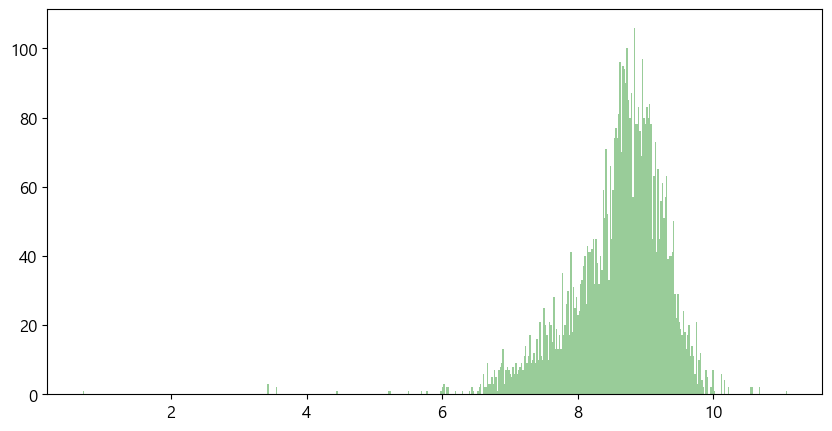

In [225]:
plt.hist(df['income'], color = 'green', alpha = 0.4, bins = 500)
plt.show()

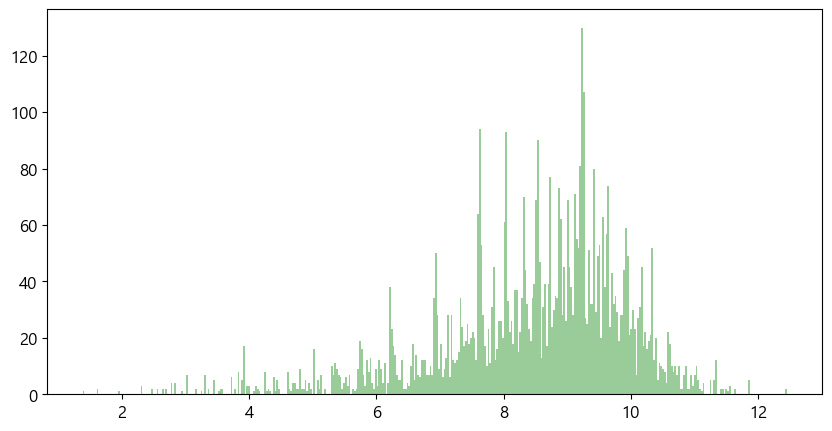

In [226]:
plt.hist(df['debt'], color = 'green', alpha = 0.4, bins = 400)
plt.show()

## 명목형 변수의 데이터 확인 및 전처리

### 나이변수의 범주화 - > 파생변수 추가

In [227]:
bins = [20,29,39,49,59,99]
labels = ['19~29세','30~39세','40~49세','50~59세','60세 이상']

cuts = pd.cut(df['age'],bins,labels=labels)
df['age_range'] = cuts
df.head()

,gen,age,religion,edu,sm_year,sm_state,sm_day,dr_mean_year,dr_6cup,dr_hurt,...,health_state,disabled,work_state,work_code,region,income,y_total,debt,y_train,age_range
0,female,78,yes,중졸,NaN,no,NaN,전혀마시지않음,NaN,NaN,...,2,abled,nowork,NaN,city,6.006353,20,9.244838,0,60세 이상
2,male,81,yes,대졸이상,NaN,no,NaN,전혀마시지않음,NaN,NaN,...,4,abled,work,762.0,city,7.742836,18,9.962747,0,60세 이상
8,female,53,yes,고졸,NaN,no,NaN,전혀마시지않음,NaN,NaN,...,2,abled,work,151.0,city,7.737093,21,6.928538,0,50~59세
9,female,31,no,중졸,NaN,no,NaN,전혀마시지않음,NaN,NaN,...,2,abled,nowork,NaN,city,7.737093,17,6.928538,0,30~39세
13,male,45,no,대졸이상,NaN,yes,14.0,월2~3회,연1회,전혀,...,4,abled,work,399.0,city,8.692658,20,9.466687,0,40~49세


In [228]:
df.drop('age',axis=1,inplace=True)
df.head()

,gen,religion,edu,sm_year,sm_state,sm_day,dr_mean_year,dr_6cup,dr_hurt,dr_worry,...,health_state,disabled,work_state,work_code,region,income,y_total,debt,y_train,age_range
0,female,yes,중졸,NaN,no,NaN,전혀마시지않음,NaN,NaN,NaN,...,2,abled,nowork,NaN,city,6.006353,20,9.244838,0,60세 이상
2,male,yes,대졸이상,NaN,no,NaN,전혀마시지않음,NaN,NaN,NaN,...,4,abled,work,762.0,city,7.742836,18,9.962747,0,60세 이상
8,female,yes,고졸,NaN,no,NaN,전혀마시지않음,NaN,NaN,NaN,...,2,abled,work,151.0,city,7.737093,21,6.928538,0,50~59세
9,female,no,중졸,NaN,no,NaN,전혀마시지않음,NaN,NaN,NaN,...,2,abled,nowork,NaN,city,7.737093,17,6.928538,0,30~39세
13,male,no,대졸이상,NaN,yes,14.0,월2~3회,연1회,전혀,전혀,...,4,abled,work,399.0,city,8.692658,20,9.466687,0,40~49세


In [229]:
df.columns

Index(['gen', 'religion', 'edu', 'sm_year', 'sm_state', 'sm_day',
       'dr_mean_year', 'dr_6cup', 'dr_hurt', 'dr_worry', 'preg_experience',
       'health_state', 'disabled', 'work_state', 'work_code', 'region',
       'income', 'y_total', 'debt', 'y_train', 'age_range'],
      dtype='object')

In [230]:
## 명목형 변수 
## gen religion edu sm_state dr_mean_year dr_6cup dr_hurt dr_worry preg_experience health_state disabled work_state income age_range

## 명목형 변수의 빈도수 확인

In [231]:
cnames = ['gen' ,'religion' ,'edu' ,'sm_state' ,'dr_mean_year','dr_6cup' ,'dr_hurt' ,'dr_worry' ,'preg_experience', 'health_state','disabled', 'work_state','age_range']

In [232]:
df['gen'].value_counts()

gen
female    2887
male      2527
Name: count, dtype: int64

In [233]:
df['religion'].value_counts()

religion
no     3015
yes    2399
Name: count, dtype: int64

In [234]:
df['edu'].value_counts()

edu
대졸이상    2686
고졸      1690
초졸이하     607
중졸       431
Name: count, dtype: int64

In [235]:
df['sm_state'].value_counts()

sm_state
no     4366
yes    1048
Name: count, dtype: int64

In [236]:
df['dr_mean_year'].value_counts()

dr_mean_year
전혀마시지않음    2459
월2~3회      1127
주2~3회       807
월1회         662
주4회이상       359
Name: count, dtype: int64

In [237]:
df['dr_6cup'].value_counts()

dr_6cup
전혀     1052
월1회     607
주1회     568
연1회     546
매일      182
Name: count, dtype: int64

In [238]:
df['dr_hurt'].value_counts()

dr_hurt
전혀      2881
과거존재      61
최근존재      13
Name: count, dtype: int64

In [239]:
df['dr_worry'].value_counts()

dr_worry
전혀      2650
최근존재     214
과거존재      91
Name: count, dtype: int64

In [240]:
df['preg_experience'].value_counts()


preg_experience
없다    2830
남성    2527
있다      57
Name: count, dtype: int64

In [241]:
df['health_state'].value_counts()


health_state
4    3150
3     995
2     645
5     563
1      61
Name: count, dtype: int64

In [242]:
df['disabled'].value_counts()


disabled
abled       5096
disabled     318
Name: count, dtype: int64

In [243]:
df['work_state'].value_counts()


work_state
work      3801
nowork    1613
Name: count, dtype: int64

In [244]:
df['age_range'].value_counts()


age_range
60세 이상    1729
40~49세    1176
50~59세    1086
30~39세     758
19~29세     656
Name: count, dtype: int64

In [245]:
cnames

['gen',
 'religion',
 'edu',
 'sm_state',
 'dr_mean_year',
 'dr_6cup',
 'dr_hurt',
 'dr_worry',
 'preg_experience',
 'health_state',
 'disabled',
 'work_state',
 'age_range']

## 데이터의 분포 확인  :  명목형 변수들의 y_train에 따른 차이 확인

### 전체적인 경향성은 나이가 많아질수록 우울감이 높게 나타난다. 특히 노년층의 우울감은 굉장히 높다

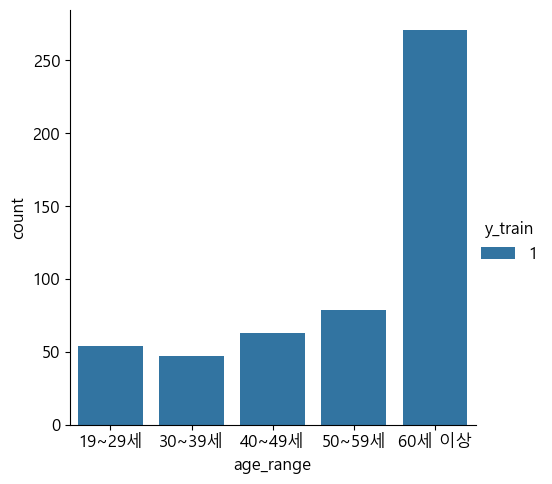

In [246]:
sns.catplot(data=df.loc[df['y_train']==1],x='age_range',kind='count',hue='y_train')

종교에 따른 우울감 경험여부는 차이가 없는것으로 보임

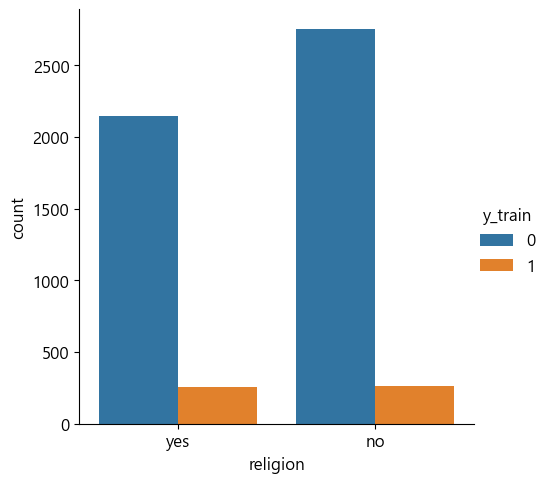

In [247]:
sns.catplot(data=df,x='religion',kind='count',hue='y_train')

교육수준에 따른 우울감 경험여부의 비율은 초졸인 사람들이 가장높았음.

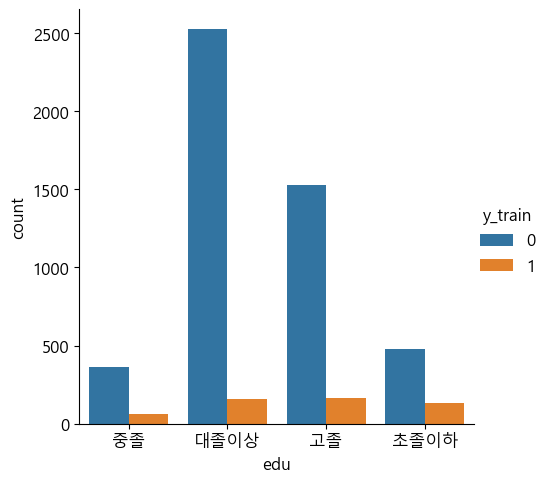

In [248]:
sns.catplot(data=df,x='edu',kind='count',hue='y_train')
plt.show()
plt.close()

흡연여부는 애매함. -> 다운샘플링 진행

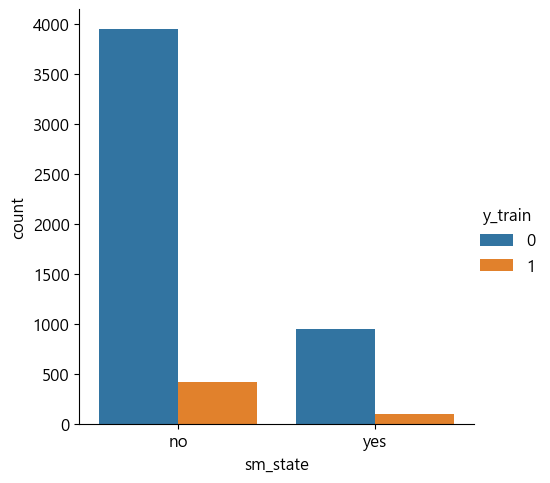

In [249]:
sns.catplot(data=df,x='sm_state',kind='count',hue='y_train')

In [250]:
from sklearn.utils import resample

subset_city_downsampled = resample(df[df['sm_state']=='no'],
                            replace=False,
                            n_samples =1048 ,
                            random_state = 2020)

In [251]:
df.columns

Index(['gen', 'religion', 'edu', 'sm_year', 'sm_state', 'sm_day',
       'dr_mean_year', 'dr_6cup', 'dr_hurt', 'dr_worry', 'preg_experience',
       'health_state', 'disabled', 'work_state', 'work_code', 'region',
       'income', 'y_total', 'debt', 'y_train', 'age_range'],
      dtype='object')

### 흡연 기간에 따른 우울감 점수 차이 없음


In [252]:
df.head()

,gen,religion,edu,sm_year,sm_state,sm_day,dr_mean_year,dr_6cup,dr_hurt,dr_worry,...,health_state,disabled,work_state,work_code,region,income,y_total,debt,y_train,age_range
0,female,yes,중졸,NaN,no,NaN,전혀마시지않음,NaN,NaN,NaN,...,2,abled,nowork,NaN,city,6.006353,20,9.244838,0,60세 이상
2,male,yes,대졸이상,NaN,no,NaN,전혀마시지않음,NaN,NaN,NaN,...,4,abled,work,762.0,city,7.742836,18,9.962747,0,60세 이상
8,female,yes,고졸,NaN,no,NaN,전혀마시지않음,NaN,NaN,NaN,...,2,abled,work,151.0,city,7.737093,21,6.928538,0,50~59세
9,female,no,중졸,NaN,no,NaN,전혀마시지않음,NaN,NaN,NaN,...,2,abled,nowork,NaN,city,7.737093,17,6.928538,0,30~39세
13,male,no,대졸이상,NaN,yes,14.0,월2~3회,연1회,전혀,전혀,...,4,abled,work,399.0,city,8.692658,20,9.466687,0,40~49세


In [253]:
sm_data = pd.concat([df[df['sm_state']=='yes'],subset_city_downsampled])
sm_data['sm_state'].value_counts()

sm_state
yes    1048
no     1048
Name: count, dtype: int64

별차이 없음>


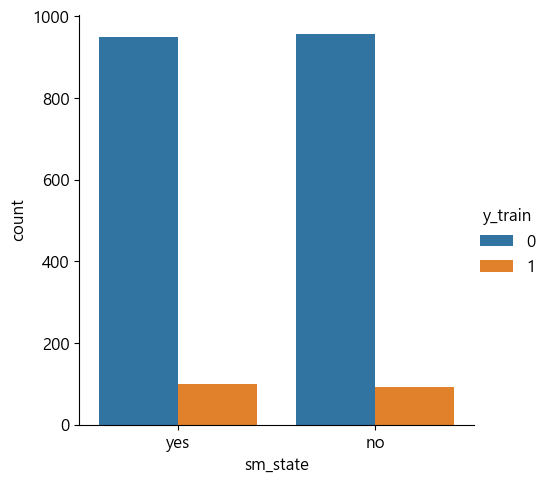

In [254]:
sns.catplot(data=sm_data,x='sm_state',kind='count',hue='y_train')

연평균 음주량도 별 차이 없어보임.

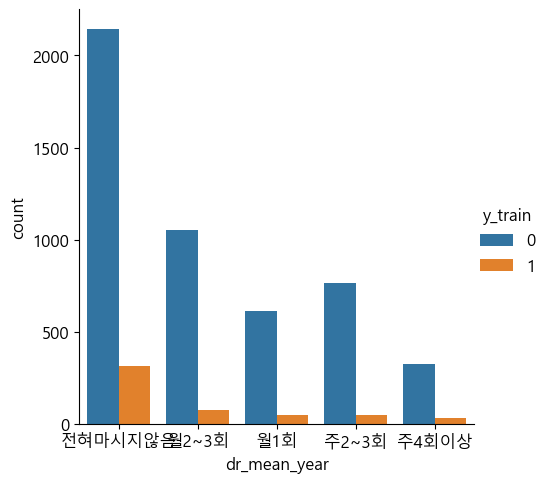

In [255]:
sns.catplot(data=df,x='dr_mean_year',kind='count',hue='y_train')

In [256]:
over_dr = df.loc[df['dr_6cup'].notnull(),:]

over_dr['dr_6cup'].isnull().sum()

0

술을 한번마실때 6잔 이상 마시는 사람들이 우울감을 느끼는가에 대한 가설은 의미 x

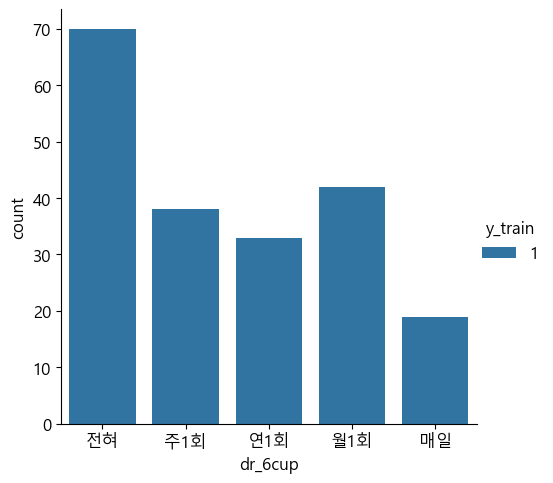

In [257]:
sns.catplot(data=over_dr.loc[over_dr['y_train']==1],x='dr_6cup',kind='count',hue='y_train')

임신경험 여부는 별 차이 없음

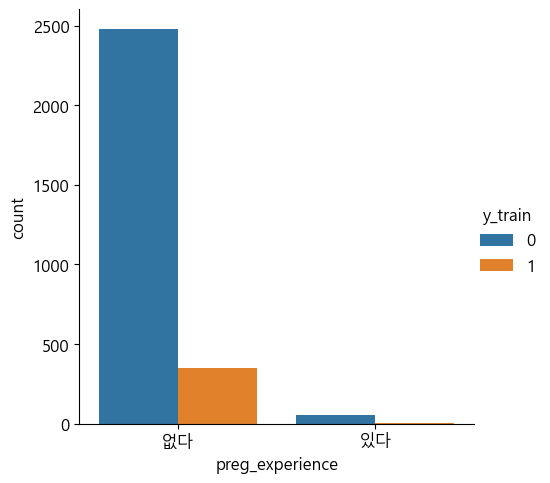

In [258]:
woman = df.loc[df['preg_experience']!='남성']
sns.catplot(data=woman,x='preg_experience',kind='count',hue='y_train')

In [259]:

subset_city_downsampled = resample(woman[woman['preg_experience']=='없다'],
                            replace=False,
                            n_samples =57 ,
                            random_state = 2020)

In [260]:
sm_data = pd.concat([woman[woman['preg_experience']=='있다'],subset_city_downsampled])
sm_data['preg_experience'].value_counts()

preg_experience
있다    57
없다    57
Name: count, dtype: int64

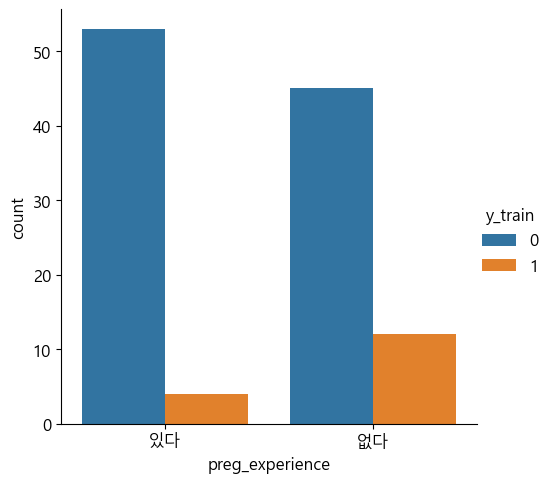

In [261]:
sns.catplot(data=sm_data,x='preg_experience',kind='count',hue='y_train')

건강 만족도가 높아지면 우울감을 경험하는 경우가 적다.

,health_state,y_total
health_state,1.000000,-0.342151
y_total,-0.342151,1.000000


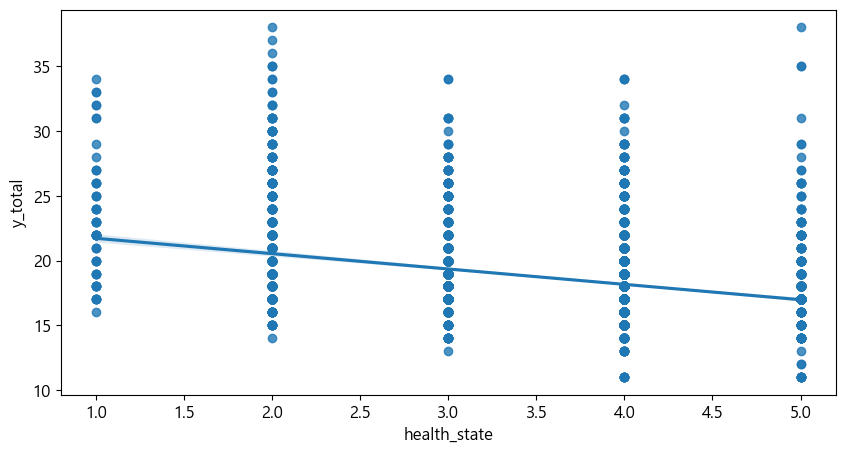

In [262]:
sns.regplot(data=df,x='health_state',y='y_total')
corr = df[['health_state','y_total']].corr(method='pearson')
corr

장애여부는 데이터의 크기 차이가 심해서 비교하기 애매함 -> 다운샘플링

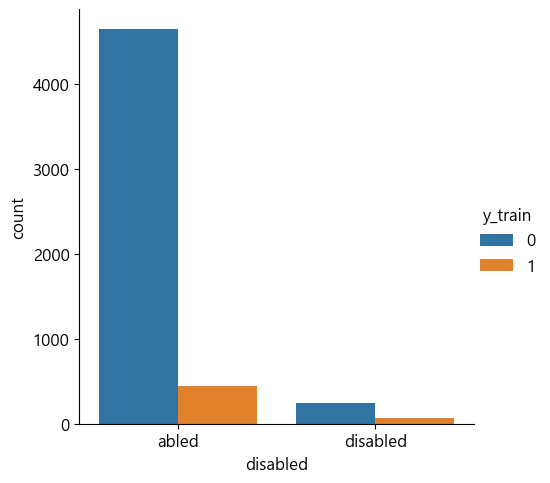

In [263]:
sns.catplot(data=df,x='disabled',kind='count',hue='y_train')

In [264]:
subset_city_downsampled = resample(df[df['disabled']=='abled'],
                            replace=False,
                            n_samples =319 ,
                            random_state = 2020)
able = pd.concat([df[df['disabled']=='disabled'],subset_city_downsampled])
able['disabled'].value_counts()

disabled
abled       319
disabled    318
Name: count, dtype: int64

차이 있음

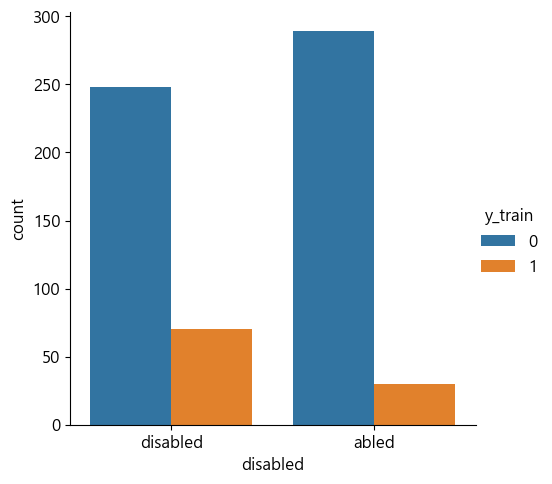

In [265]:
sns.catplot(data=able,x='disabled',kind='count',hue='y_train')

In [266]:
df['work_state'].unique()

array(['nowork', 'work'], dtype=object)

In [267]:
df['work_state'].value_counts()

work_state
work      3801
nowork    1613
Name: count, dtype: int64

노동여부에 따라 차이 많이 남

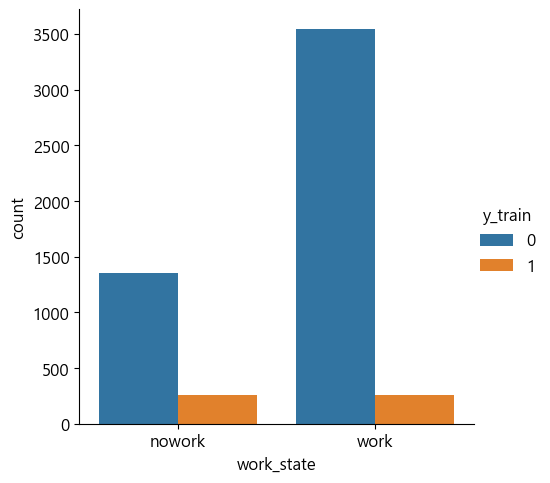

In [268]:
sns.catplot(data=df,x='work_state',kind='count',hue='y_train')

사는 지역에 따라 우울감 경험의차이는 없ㅇ므

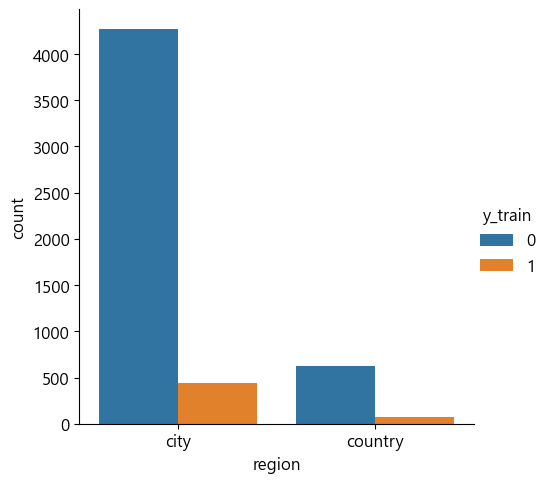

In [269]:
sns.catplot(data=df,x='region',kind='count',hue='y_train')

In [270]:

subset_city_downsampled = resample(df[df['region']=='city'],
                            replace=False,
                            n_samples =696 ,
                            random_state = 2020)
city = pd.concat([df[df['region']=='country'],subset_city_downsampled])
city['region'].value_counts()

region
country    696
city       696
Name: count, dtype: int64

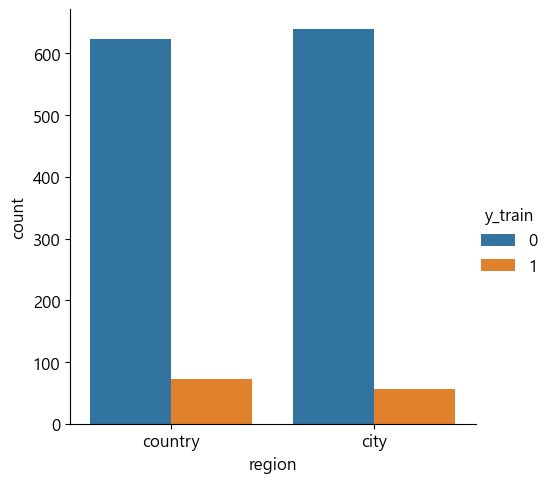

In [271]:
sns.catplot(data=city,x='region',kind='count',hue='y_train')

성별에 따른 차이 잇음

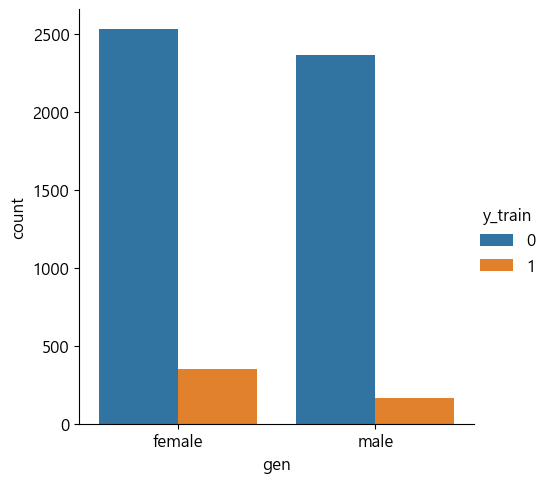

In [272]:
sns.catplot(data=df,x='gen',kind='count',hue='y_train')

In [273]:
df.head()

,gen,religion,edu,sm_year,sm_state,sm_day,dr_mean_year,dr_6cup,dr_hurt,dr_worry,...,health_state,disabled,work_state,work_code,region,income,y_total,debt,y_train,age_range
0,female,yes,중졸,NaN,no,NaN,전혀마시지않음,NaN,NaN,NaN,...,2,abled,nowork,NaN,city,6.006353,20,9.244838,0,60세 이상
2,male,yes,대졸이상,NaN,no,NaN,전혀마시지않음,NaN,NaN,NaN,...,4,abled,work,762.0,city,7.742836,18,9.962747,0,60세 이상
8,female,yes,고졸,NaN,no,NaN,전혀마시지않음,NaN,NaN,NaN,...,2,abled,work,151.0,city,7.737093,21,6.928538,0,50~59세
9,female,no,중졸,NaN,no,NaN,전혀마시지않음,NaN,NaN,NaN,...,2,abled,nowork,NaN,city,7.737093,17,6.928538,0,30~39세
13,male,no,대졸이상,NaN,yes,14.0,월2~3회,연1회,전혀,전혀,...,4,abled,work,399.0,city,8.692658,20,9.466687,0,40~49세


In [274]:
df.columns

Index(['gen', 'religion', 'edu', 'sm_year', 'sm_state', 'sm_day',
       'dr_mean_year', 'dr_6cup', 'dr_hurt', 'dr_worry', 'preg_experience',
       'health_state', 'disabled', 'work_state', 'work_code', 'region',
       'income', 'y_total', 'debt', 'y_train', 'age_range'],
      dtype='object')

## 변수 골라내기 

In [275]:
df = df.loc[:,['gen','edu','health_state','disabled','work_state','income','y_total','debt','y_train','age_range']]
df.head()

,gen,edu,health_state,disabled,work_state,income,y_total,debt,y_train,age_range
0,female,중졸,2,abled,nowork,6.006353,20,9.244838,0,60세 이상
2,male,대졸이상,4,abled,work,7.742836,18,9.962747,0,60세 이상
8,female,고졸,2,abled,work,7.737093,21,6.928538,0,50~59세
9,female,중졸,2,abled,nowork,7.737093,17,6.928538,0,30~39세
13,male,대졸이상,4,abled,work,8.692658,20,9.466687,0,40~49세


## 변수들의 카테고리화 과정

In [276]:
df['age_range']= df['age_range'].astype('str')
df['age_range'].unique()

array(['60세 이상', '50~59세', '30~39세', '40~49세', '19~29세', 'nan'],
      dtype=object)

In [277]:
df['age_range'] = df['age_range'].fillna(0)
df = df.loc[df['age_range']!=0,:]

In [278]:
df.head()

,gen,edu,health_state,disabled,work_state,income,y_total,debt,y_train,age_range
0,female,중졸,2,abled,nowork,6.006353,20,9.244838,0,60세 이상
2,male,대졸이상,4,abled,work,7.742836,18,9.962747,0,60세 이상
8,female,고졸,2,abled,work,7.737093,21,6.928538,0,50~59세
9,female,중졸,2,abled,nowork,7.737093,17,6.928538,0,30~39세
13,male,대졸이상,4,abled,work,8.692658,20,9.466687,0,40~49세


In [279]:
# df=df.loc[:,['gen','edu','health_state','disabled','work_state','y_train','age_range','log_income','log_debt']]
# df.head()

In [280]:
df.loc[df['gen']=='male','gen']=1
df.loc[df['gen']=='female','gen']=2
df['gen'] = df['gen'].astype('category')

df.loc[df['edu']=='초졸이하','edu']=1
df.loc[df['edu']=='중졸','edu']=2
df.loc[df['edu']=='고졸','edu']=3
df.loc[df['edu']=='대졸이상','edu']=4
df['edu'] = df['edu'].astype('category')

df.loc[df['disabled']=='disabled','disabled']=1
df.loc[df['disabled']=='abled','disabled']=2
df['disabled'] = df['disabled'].astype('category')


df.loc[df['work_state']=='work','work_state']=1
df.loc[df['work_state']=='nowork','work_state']=2
df['work_state'] = df['work_state'].astype('category')

df['age_range'] = df['age_range'].astype('str')
df.loc[df['age_range']=='19~29세','age_range']=1
df.loc[df['age_range']=='30~39세','age_range']=2
df.loc[df['age_range']=='40~49세','age_range']=3
df.loc[df['age_range']=='50~59세','age_range']=4
df.loc[df['age_range']=='60세 이상','age_range']=5
df['age_range'] = df['age_range'].astype('category')


# df= pd.get_dummies(test,drop_first=True,dtype='int')
# df.columns

In [281]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5414 entries, 0 to 13473
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   gen           5414 non-null   category
 1   edu           5414 non-null   category
 2   health_state  5414 non-null   int64   
 3   disabled      5414 non-null   category
 4   work_state    5414 non-null   category
 5   income        5414 non-null   float64 
 6   y_total       5414 non-null   int64   
 7   debt          5414 non-null   float64 
 8   y_train       5414 non-null   int64   
 9   age_range     5414 non-null   category
dtypes: category(5), float64(2), int64(3)
memory usage: 281.0 KB


In [282]:
df['health_state'].unique()

array([2, 4, 3, 5, 1], dtype=int64)

In [283]:
### 건강만족도 ㄱㄱ 

ctype = pd.CategoricalDtype(categories=[1,2,3,4,5], ordered=True)

df['health_state'] = df['health_state'].astype(ctype)

df['health_state'].dtypes


CategoricalDtype(categories=[1, 2, 3, 4, 5], ordered=True)

## 가설 검정 - 연속형 변수
### 정규성 검정

In [284]:
stats.normaltest(df['income'])

NormaltestResult(statistic=1747.4194887987817, pvalue=0.0)

In [285]:
stats.normaltest(df['debt'])
## 성립 x 

NormaltestResult(statistic=902.8790811642938, pvalue=8.755856035202143e-197)

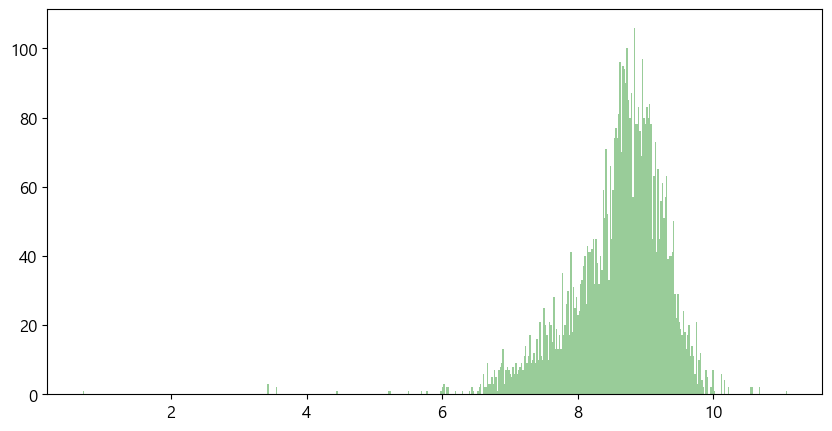

In [286]:
plt.hist(df['income'], color = 'green', alpha = 0.4, bins = 500)
plt.show()


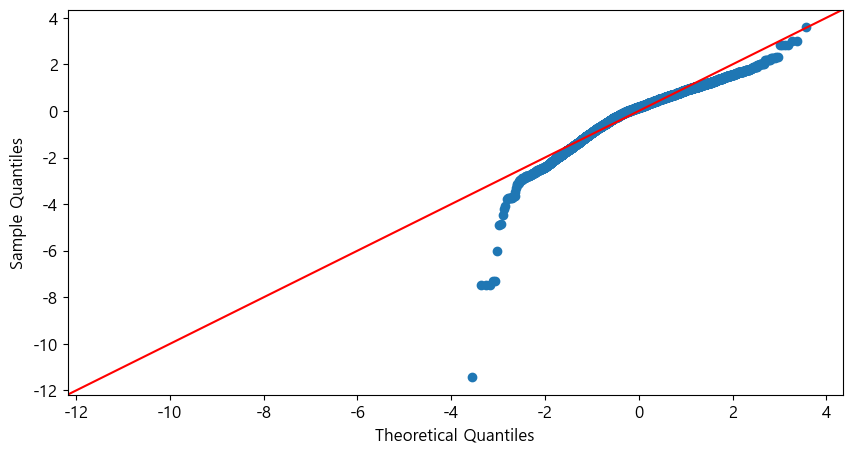

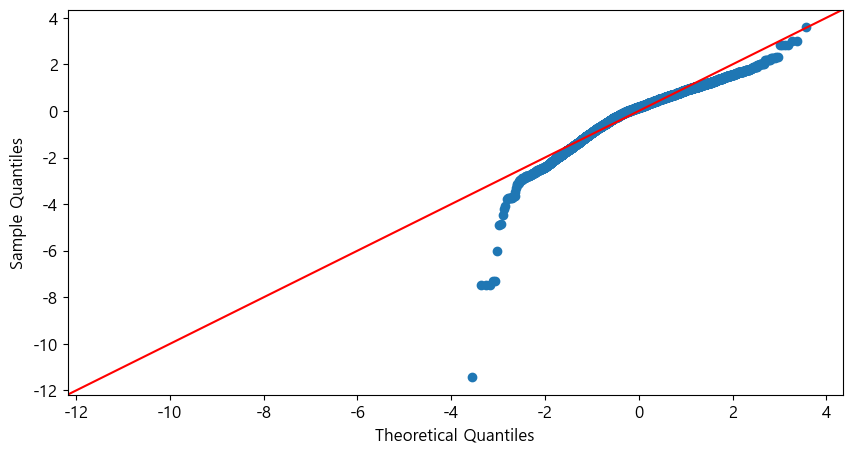

In [287]:
sm.qqplot(df['income'], line='45', fit = True)

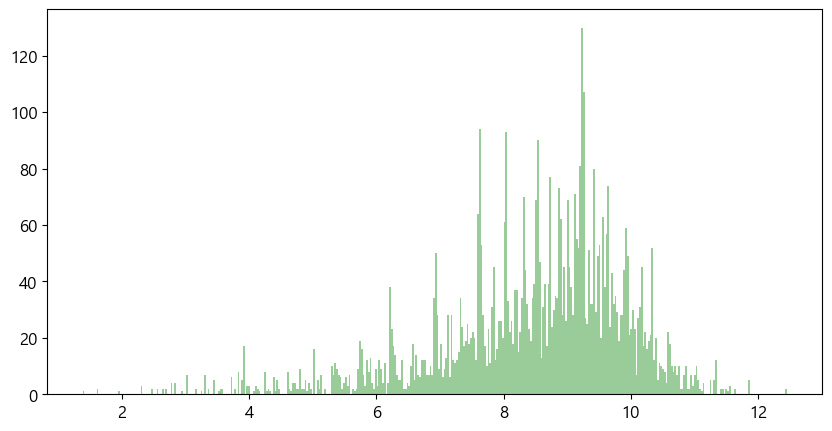

In [288]:
plt.hist(df['debt'], color = 'green', alpha = 0.4, bins = 400)
plt.show()

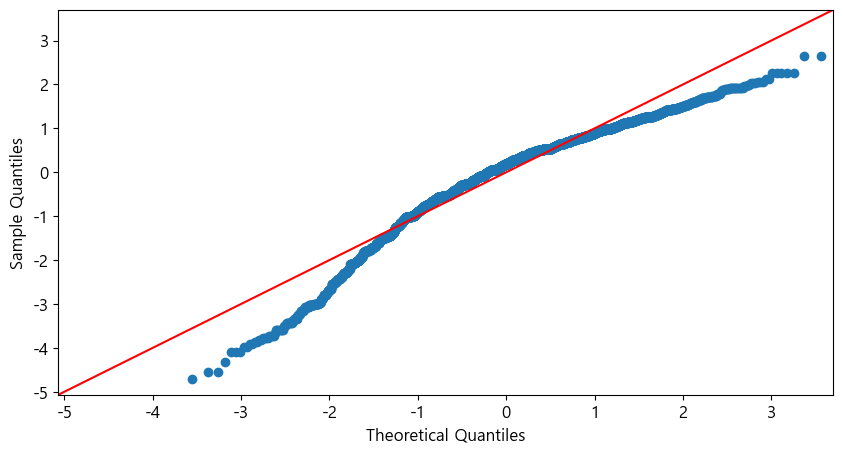

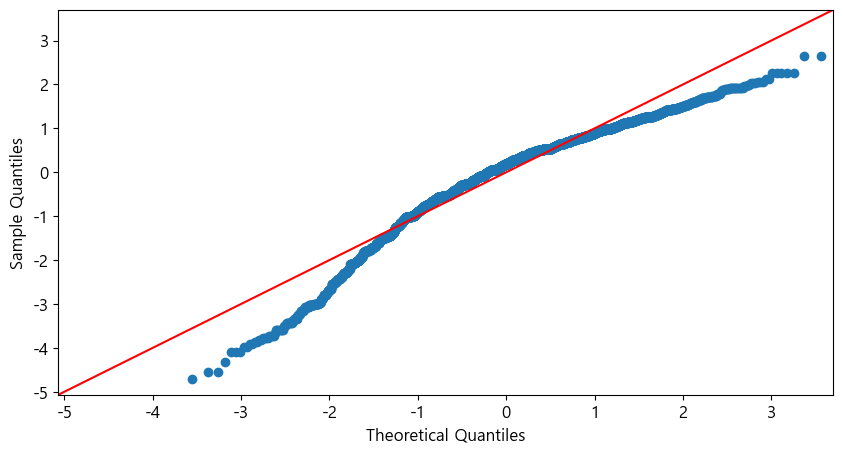

In [289]:
sm.qqplot(df['debt'], line='45', fit = True)

#### 정규성 검정 결과는 p값이 0에 가까우나 표본의 수가 크다는 점과, 히스토그램 및 qq플롯 시각화 결과 어느정도의 정규성을 띄는걸로 확인했기떄문에 정규성을 가정하고 분석을 진행

### 등분산성 
#### 우울감을 느끼는 집단과 안느끼는 집단의 분산이 같은지 검정

In [290]:
data=pd.read_excel("빚추가마지막.xlsx")

In [291]:
train = data.loc[(data['income']>27),:]
train['income'] = np.log1p(train['income'])

C:\Users\user\AppData\Local\Temp\ipykernel_12780\2571767070.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['income'] = np.log1p(train['income'])


In [292]:
train.head()

,Unnamed: 0,gen,age,religion,edu,sm_year,sm_state,sm_day,dr_mean_year,dr_6cup,...,preg_experience,health_state,disabled,work_state,work_code,region,income,y_total,debt,y_train
0,0,female,78,yes,중졸,NaN,no,NaN,전혀마시지않음,NaN,...,없다,2,abled,nowork,NaN,city,6.006353,20,10350.0,0
1,1,male,75,no,초졸이하,NaN,no,NaN,전혀마시지않음,NaN,...,남성,1,abled,work,942.0,city,7.933438,29,0.0,1
2,2,male,81,yes,대졸이상,NaN,no,NaN,전혀마시지않음,NaN,...,남성,4,abled,work,762.0,city,7.742836,18,21220.0,0
3,3,male,61,yes,대졸이상,NaN,no,NaN,전혀마시지않음,NaN,...,남성,4,abled,work,855.0,city,8.562549,20,0.0,0
4,4,female,60,yes,고졸,NaN,no,NaN,전혀마시지않음,NaN,...,없다,4,abled,work,399.0,city,8.562549,21,0.0,0


In [293]:
y_income_0 = train.loc[train['y_train']==0,'income']
y_income_1 = train.loc[train['y_train']==1,'income']

In [294]:
stats.levene(y_income_1,y_income_0)

LeveneResult(statistic=0.023232134473999987, pvalue=0.8788572576668049)

In [295]:
y_train_debt_0 = df.loc[df['y_train']==0,'debt']
y_train_debt_1 = df.loc[df['y_train']==1,'debt']

In [296]:
stats.levene(y_train_debt_1,y_train_debt_0)

LeveneResult(statistic=3.6671032100108305, pvalue=0.05554921572874413)

## 명목형 변수의 검정 - 카이제곱 검정 

In [297]:
df.columns

Index(['gen', 'edu', 'health_state', 'disabled', 'work_state', 'income',
       'y_total', 'debt', 'y_train', 'age_range'],
      dtype='object')

In [298]:
from scipy.stats import chi2_contingency
result_gen = pd.crosstab(df['gen'],df['y_train'])
chiresult_gen = chi2_contingency(observed=result_gen)
chiresult_gen

Chi2ContingencyResult(statistic=52.82640062154608, pvalue=3.643704777736139e-13, dof=1, expected_freq=array([[2286.15552272,  240.84447728],
       [2611.84447728,  275.15552272]]))

In [299]:
result_edu = pd.crosstab(df['edu'],df['y_train'])
chiresult_edu = chi2_contingency(observed=result_edu)
chiresult_edu

Chi2ContingencyResult(statistic=159.10232692000645, pvalue=2.8631980008510046e-34, dof=3, expected_freq=array([[ 549.14776505,   57.85223495],
       [ 389.92205393,   41.07794607],
       [1528.92870336,  161.07129664],
       [2430.00147765,  255.99852235]]))

In [300]:
result_health_state = pd.crosstab(df['health_state'],df['y_train'])
chiresult_health_state = chi2_contingency(observed=result_health_state)
chiresult_health_state

Chi2ContingencyResult(statistic=447.5737358381009, pvalue=1.4533461899751813e-95, dof=4, expected_freq=array([[  55.18618397,    5.81381603],
       [ 583.52604359,   61.47395641],
       [ 900.16808275,   94.83191725],
       [2849.77835242,  300.22164758],
       [ 509.34133727,   53.65866273]]))

In [301]:
result_disabled = pd.crosstab(df['disabled'],df['y_train'])
chiresult_disabled = chi2_contingency(observed=result_disabled)
chiresult_disabled

Chi2ContingencyResult(statistic=59.51447238967723, pvalue=1.2139806889961367e-14, dof=1, expected_freq=array([[ 287.69190986,   30.30809014],
       [4610.30809014,  485.69190986]]))

In [302]:
result_work_state = pd.crosstab(df['work_state'],df['y_train'])
chiresult_work_state = chi2_contingency(observed=result_work_state)
chiresult_work_state

Chi2ContingencyResult(statistic=118.9403703663307, pvalue=1.0792561563352741e-27, dof=1, expected_freq=array([[3438.73254525,  362.26745475],
       [1459.26745475,  153.73254525]]))

In [303]:
df.head()

,gen,edu,health_state,disabled,work_state,income,y_total,debt,y_train,age_range
0,2,2,2,2,2,6.006353,20,9.244838,0,5
2,1,4,4,2,1,7.742836,18,9.962747,0,5
8,2,3,2,2,1,7.737093,21,6.928538,0,4
9,2,2,2,2,2,7.737093,17,6.928538,0,2
13,1,4,4,2,1,8.692658,20,9.466687,0,3


In [304]:
df = df.drop('y_total',axis=1)


In [305]:
y_data = df['y_train']
new_df = df.drop('y_train',axis=1)
new_df = pd.get_dummies(new_df,drop_first=True,dtype='int')
new_df.head()

,income,debt,gen_2,edu_2,edu_3,edu_4,health_state_2,health_state_3,health_state_4,health_state_5,disabled_2,work_state_2,age_range_2,age_range_3,age_range_4,age_range_5,age_range_nan
0,6.006353,9.244838,1,1,0,0,1,0,0,0,1,1,0,0,0,1,0
2,7.742836,9.962747,0,0,0,1,0,0,1,0,1,0,0,0,0,1,0
8,7.737093,6.928538,1,0,1,0,1,0,0,0,1,0,0,0,1,0,0
9,7.737093,6.928538,1,1,0,0,1,0,0,0,1,1,1,0,0,0,0
13,8.692658,9.466687,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0


In [306]:
y_data= pd.DataFrame(y_data,columns=['y_train'])

In [307]:
new_df = new_df.drop('age_range_nan',axis=1)
new_df['y_train'] = y_data['y_train']

In [308]:
new_df.columns

Index(['income', 'debt', 'gen_2', 'edu_2', 'edu_3', 'edu_4', 'health_state_2',
       'health_state_3', 'health_state_4', 'health_state_5', 'disabled_2',
       'work_state_2', 'age_range_2', 'age_range_3', 'age_range_4',
       'age_range_5', 'y_train'],
      dtype='object')

In [309]:
new_df.head()

,income,debt,gen_2,edu_2,edu_3,edu_4,health_state_2,health_state_3,health_state_4,health_state_5,disabled_2,work_state_2,age_range_2,age_range_3,age_range_4,age_range_5,y_train
0,6.006353,9.244838,1,1,0,0,1,0,0,0,1,1,0,0,0,1,0
2,7.742836,9.962747,0,0,0,1,0,0,1,0,1,0,0,0,0,1,0
8,7.737093,6.928538,1,0,1,0,1,0,0,0,1,0,0,0,1,0,0
9,7.737093,6.928538,1,1,0,0,1,0,0,0,1,1,1,0,0,0,0
13,8.692658,9.466687,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0


In [310]:
x_col = new_df.columns
x_col = x_col[:-1]
x_col

Index(['income', 'debt', 'gen_2', 'edu_2', 'edu_3', 'edu_4', 'health_state_2',
       'health_state_3', 'health_state_4', 'health_state_5', 'disabled_2',
       'work_state_2', 'age_range_2', 'age_range_3', 'age_range_4',
       'age_range_5'],
      dtype='object')

In [311]:
from scipy.stats import stats
from statsmodels.formula.api import logit
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


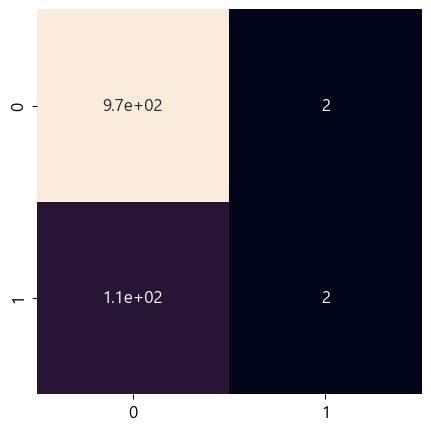

In [312]:
x_tr, x_val, y_tr, y_val = train_test_split(new_df[x_col], new_df['y_train'], test_size=0.2, shuffle=True, random_state=20)

# 로지스틱 회귀 모델
from sklearn.linear_model import LogisticRegression
lr_model = LogisticRegression()
lr_model.fit(x_tr, y_tr)
y_val_pred = lr_model.predict(x_val)

# conFusion Matrix
from sklearn.metrics import confusion_matrix
sns.heatmap(confusion_matrix(y_val, y_val_pred), annot=True,  cbar=False, square=True)
plt.show()

In [313]:
# 평가지표
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score
print("Accuracy:%.4f" % accuracy_score(y_val, y_val_pred))
print("Precision:%.4f" % precision_score(y_val, y_val_pred))
print("recall:%.4f" % recall_score(y_val, y_val_pred))
print("F1:%.4f" % f1_score(y_val, y_val_pred))
print("roc_auc:%.4f" % roc_auc_score(y_val, y_val_pred))

Accuracy:0.9003
Precision:0.5000
recall:0.0185
F1:0.0357
roc_auc:0.5082


In [314]:
y_tr = pd.DataFrame(y_tr,columns=['y_train'])

In [315]:
x_tr['y_train']= y_tr['y_train']

In [316]:
model = logit('y_train ~ x_tr[x_col]',data=x_tr)
fit = model.fit()
fit.summary()

Optimization terminated successfully.
         Current function value: 0.268461
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                y_train   No. Observations:                 4331
Model:                          Logit   Df Residuals:                     4314
Method:                           MLE   Df Model:                           16
Date:                Fri, 18 Aug 2023   Pseudo R-squ.:                  0.1400
Time:                        17:48:05   Log-Likelihood:                -1162.7
converged:                       True   LL-Null:                       -1352.0
Covariance Type:            nonrobust   LLR p-value:                 1.149e-70
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           3.6405      0.747      4.875      0.000       2.177       5.104
x_tr[x_col][0]     -0.4293      0.076     -5.655      0.000      -0.578      -0.281
x_tr[x_col][1]     -0.0424      0.038     -1.121      0.262      -0.116       0.032
x_tr[x_col][2]      0.6098      0.122      5.012      0.000       0.371       0.848
x_tr[x_col][3]     -0.0653      0.199     -0.328      0.743      -0.456       0.325
x_tr[x_col][4]     -0.0352      0.181     -0.194      0.846      -0.390       0.320
x_tr[x_col][5]     -0.4479      0.214     -2.090      0.037      -0.868      -0.028
x_tr[x_col][6]     -0.7268      0.313     -2.320      0.020      -1.341      -0.113
x_tr[x_col][7]     -1.4738      0.321     -4.593      0.000      -2.103      -0.845
x_tr[x_col][8]     -2.0377      0.325     -6.278      0.000      -2.674      -1.402
x_tr[x_col][9]     -1.9534      0.385     -5.079      0.000      -2.707      -1.200
x_tr[x_col][10]    -0.2630      0.186     -1.416      0.157      -0.627       0.101
x_tr[x_col][11]     0.4434      0.118      3.763      0.000       0.212       0.674
x_tr[x_col][12]    -0.2946      0.237     -1.241      0.215      -0.760       0.171
x_tr[x_col][13]    -0.5935      0.226     -2.625      0.009      -1.037      -0.150
x_tr[x_col][14]    -0.5438      0.228     -2.386      0.017      -0.991      -0.097
x_tr[x_col][15]    -0.5404      0.231     -2.341      0.019      -0.993      -0.088
===================================================================================
"""

In [317]:
x_col

Index(['income', 'debt', 'gen_2', 'edu_2', 'edu_3', 'edu_4', 'health_state_2',
       'health_state_3', 'health_state_4', 'health_state_5', 'disabled_2',
       'work_state_2', 'age_range_2', 'age_range_3', 'age_range_4',
       'age_range_5'],
      dtype='object')

In [318]:
new_df[x_col][1]  = 'debt'

new_df[x_col][3] = 'edu_2'

new_df[x_col][4] = 'edu_3'

new_df[x_col][5] = 'edu_4'

new_df[x_col][12] = 'age_range_2'


In [319]:
new_df = new_df.drop(['debt','edu_2','edu_3','edu_4','age_range_2'],axis=1)
new_df.head()

,income,gen_2,health_state_2,health_state_3,health_state_4,health_state_5,disabled_2,work_state_2,age_range_3,age_range_4,age_range_5,y_train
0,6.006353,1,1,0,0,0,1,1,0,0,1,0
2,7.742836,0,0,0,1,0,1,0,0,0,1,0
8,7.737093,1,1,0,0,0,1,0,0,1,0,0
9,7.737093,1,1,0,0,0,1,1,0,0,0,0
13,8.692658,0,0,0,1,0,1,0,1,0,0,0


In [320]:
x_col = new_df.columns
x_col = x_col[:-1]
x_col

Index(['income', 'gen_2', 'health_state_2', 'health_state_3', 'health_state_4',
       'health_state_5', 'disabled_2', 'work_state_2', 'age_range_3',
       'age_range_4', 'age_range_5'],
      dtype='object')

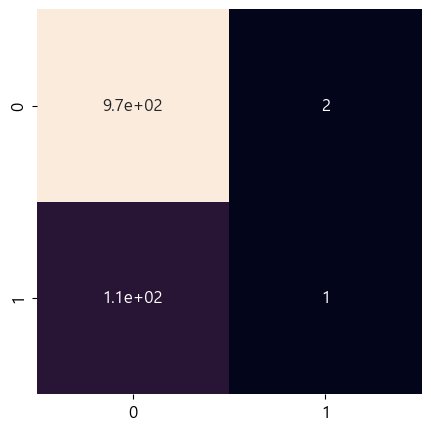

Accuracy:0.8994
Precision:0.3333
recall:0.0093
F1:0.0180
roc_auc:0.5036


In [321]:
x_tr, x_val, y_tr, y_val = train_test_split(new_df[x_col], new_df['y_train'], test_size=0.2, shuffle=True, random_state=20)

# 로지스틱 회귀 모델
from sklearn.linear_model import LogisticRegression
lr_model = LogisticRegression()
lr_model.fit(x_tr, y_tr)
y_val_pred = lr_model.predict(x_val)

# conFusion Matrix
from sklearn.metrics import confusion_matrix
sns.heatmap(confusion_matrix(y_val, y_val_pred), annot=True,  cbar=False, square=True)
# cbar를 통해 colorbar의 유무를 정해 줄 수 있고
# linewidths 각 cell마다 선을 넣어주고 굵기를 정할 수 있다.
# annot 각 cell의 값을 표기할 수 있다. 이때 fmt를 이용해 각 cell 값의 데이터 형태를 지정해주는 과정이 필요할 수 있다.
# vmin, vmax로 색으로 최대값, 최소값을 표현할 수 있다. ex) vmin = 200, vmax=500
plt.show()
# 평가지표
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score
print("Accuracy:%.4f" % accuracy_score(y_val, y_val_pred))
print("Precision:%.4f" % precision_score(y_val, y_val_pred))
print("recall:%.4f" % recall_score(y_val, y_val_pred))
print("F1:%.4f" % f1_score(y_val, y_val_pred))
print("roc_auc:%.4f" % roc_auc_score(y_val, y_val_pred))

In [322]:
y_tr = pd.DataFrame(y_tr,columns=['y_train'])
x_tr['y_train']= y_tr['y_train']

In [323]:
model = logit('y_train ~ x_tr[x_col]',data=x_tr)
fit = model.fit()
fit.summary()

Optimization terminated successfully.
         Current function value: 0.269759
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                y_train   No. Observations:                 4331
Model:                          Logit   Df Residuals:                     4319
Method:                           MLE   Df Model:                           11
Date:                Fri, 18 Aug 2023   Pseudo R-squ.:                  0.1358
Time:                        17:48:05   Log-Likelihood:                -1168.3
converged:                       True   LL-Null:                       -1352.0
Covariance Type:            nonrobust   LLR p-value:                 5.337e-72
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           3.1258      0.708      4.418      0.000       1.739       4.513
x_tr[x_col][0]     -0.4637      0.074     -6.254      0.000      -0.609      -0.318
x_tr[x_col][1]      0.6291      0.120      5.236      0.000       0.394       0.865
x_tr[x_col][2]     -0.7346      0.312     -2.357      0.018      -1.346      -0.124
x_tr[x_col][3]     -1.4989      0.319     -4.701      0.000      -2.124      -0.874
x_tr[x_col][4]     -2.0898      0.322     -6.487      0.000      -2.721      -1.458
x_tr[x_col][5]     -2.0211      0.382     -5.291      0.000      -2.770      -1.272
x_tr[x_col][6]     -0.2810      0.185     -1.516      0.130      -0.644       0.082
x_tr[x_col][7]      0.4568      0.117      3.912      0.000       0.228       0.686
x_tr[x_col][8]     -0.3894      0.194     -2.006      0.045      -0.770      -0.009
x_tr[x_col][9]     -0.2286      0.188     -1.219      0.223      -0.596       0.139
x_tr[x_col][10]    -0.1268      0.167     -0.760      0.448      -0.454       0.200
===================================================================================
"""

In [324]:
x_col

Index(['income', 'gen_2', 'health_state_2', 'health_state_3', 'health_state_4',
       'health_state_5', 'disabled_2', 'work_state_2', 'age_range_3',
       'age_range_4', 'age_range_5'],
      dtype='object')

In [325]:

new_df[x_col][9]  = 'age_range_4'
new_df[x_col][10] = 'age_range_5'

In [326]:
new_df = new_df.drop(['age_range_4','age_range_5'],axis=1)
new_df.head()

,income,gen_2,health_state_2,health_state_3,health_state_4,health_state_5,disabled_2,work_state_2,age_range_3,y_train
0,6.006353,1,1,0,0,0,1,1,0,0
2,7.742836,0,0,0,1,0,1,0,0,0
8,7.737093,1,1,0,0,0,1,0,0,0
9,7.737093,1,1,0,0,0,1,1,0,0
13,8.692658,0,0,0,1,0,1,0,1,0


In [327]:
x_col = new_df.columns
x_col = x_col[:-1]
x_col

Index(['income', 'gen_2', 'health_state_2', 'health_state_3', 'health_state_4',
       'health_state_5', 'disabled_2', 'work_state_2', 'age_range_3'],
      dtype='object')

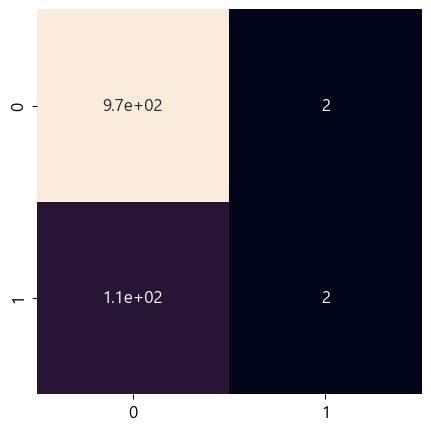

Accuracy:0.9003
Precision:0.5000
recall:0.0185
F1:0.0357
roc_auc:0.5082


In [328]:
x_tr, x_val, y_tr, y_val = train_test_split(new_df[x_col], new_df['y_train'], test_size=0.2, shuffle=True, random_state=20)

# 로지스틱 회귀 모델
from sklearn.linear_model import LogisticRegression
lr_model = LogisticRegression()
lr_model.fit(x_tr, y_tr)
y_val_pred = lr_model.predict(x_val)

# conFusion Matrix
from sklearn.metrics import confusion_matrix
sns.heatmap(confusion_matrix(y_val, y_val_pred), annot=True,  cbar=False, square=True)
# cbar를 통해 colorbar의 유무를 정해 줄 수 있고
# linewidths 각 cell마다 선을 넣어주고 굵기를 정할 수 있다.
# annot 각 cell의 값을 표기할 수 있다. 이때 fmt를 이용해 각 cell 값의 데이터 형태를 지정해주는 과정이 필요할 수 있다.
# vmin, vmax로 색으로 최대값, 최소값을 표현할 수 있다. ex) vmin = 200, vmax=500
plt.show()
# 평가지표
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score
print("Accuracy:%.4f" % accuracy_score(y_val, y_val_pred))
print("Precision:%.4f" % precision_score(y_val, y_val_pred))
print("recall:%.4f" % recall_score(y_val, y_val_pred))
print("F1:%.4f" % f1_score(y_val, y_val_pred))
print("roc_auc:%.4f" % roc_auc_score(y_val, y_val_pred))

In [329]:
y_tr = pd.DataFrame(y_tr,columns=['y_train'])
x_tr['y_train']= y_tr['y_train']

In [330]:
model = logit('y_train ~ x_tr[x_col]',data=x_tr)
fit = model.fit()
fit.summary()

Optimization terminated successfully.
         Current function value: 0.269932
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                y_train   No. Observations:                 4331
Model:                          Logit   Df Residuals:                     4321
Method:                           MLE   Df Model:                            9
Date:                Fri, 18 Aug 2023   Pseudo R-squ.:                  0.1353
Time:                        17:48:05   Log-Likelihood:                -1169.1
converged:                       True   LL-Null:                       -1352.0
Covariance Type:            nonrobust   LLR p-value:                 2.719e-73
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          2.9317      0.654      4.481      0.000       1.649       4.214
x_tr[x_col][0]    -0.4588      0.073     -6.323      0.000      -0.601      -0.317
x_tr[x_col][1]     0.6281      0.120      5.226      0.000       0.393       0.864
x_tr[x_col][2]    -0.7280      0.311     -2.338      0.019      -1.338      -0.118
x_tr[x_col][3]    -1.4910      0.318     -4.682      0.000      -2.115      -0.867
x_tr[x_col][4]    -2.0567      0.317     -6.481      0.000      -2.679      -1.435
x_tr[x_col][5]    -1.9499      0.372     -5.237      0.000      -2.680      -1.220
x_tr[x_col][6]    -0.2675      0.185     -1.449      0.147      -0.629       0.094
x_tr[x_col][7]     0.4741      0.116      4.086      0.000       0.247       0.701
x_tr[x_col][8]    -0.2852      0.169     -1.687      0.092      -0.617       0.046
==================================================================================
"""

In [331]:
x_col

Index(['income', 'gen_2', 'health_state_2', 'health_state_3', 'health_state_4',
       'health_state_5', 'disabled_2', 'work_state_2', 'age_range_3'],
      dtype='object')

In [332]:
new_df = new_df.drop(['age_range_3'],axis=1)
new_df.head()

,income,gen_2,health_state_2,health_state_3,health_state_4,health_state_5,disabled_2,work_state_2,y_train
0,6.006353,1,1,0,0,0,1,1,0
2,7.742836,0,0,0,1,0,1,0,0
8,7.737093,1,1,0,0,0,1,0,0
9,7.737093,1,1,0,0,0,1,1,0
13,8.692658,0,0,0,1,0,1,0,0


In [333]:
x_col = new_df.columns
x_col = x_col[:-1]
x_col

Index(['income', 'gen_2', 'health_state_2', 'health_state_3', 'health_state_4',
       'health_state_5', 'disabled_2', 'work_state_2'],
      dtype='object')

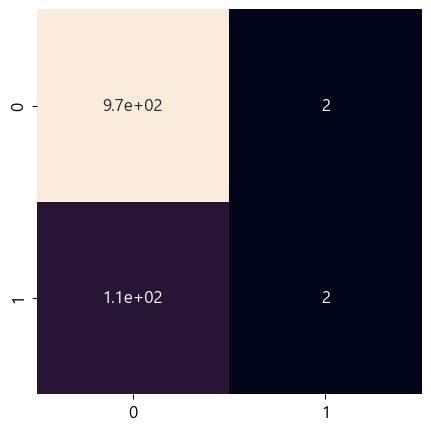

Accuracy:0.9003
Precision:0.5000
recall:0.0185
F1:0.0357
roc_auc:0.5082


In [334]:
x_tr, x_val, y_tr, y_val = train_test_split(new_df[x_col], new_df['y_train'], test_size=0.2, shuffle=True, random_state=20)

# 로지스틱 회귀 모델
from sklearn.linear_model import LogisticRegression
lr_model = LogisticRegression()
lr_model.fit(x_tr, y_tr)
y_val_pred = lr_model.predict(x_val)

# conFusion Matrix
from sklearn.metrics import confusion_matrix
sns.heatmap(confusion_matrix(y_val, y_val_pred), annot=True,  cbar=False, square=True)
# cbar를 통해 colorbar의 유무를 정해 줄 수 있고
# linewidths 각 cell마다 선을 넣어주고 굵기를 정할 수 있다.
# annot 각 cell의 값을 표기할 수 있다. 이때 fmt를 이용해 각 cell 값의 데이터 형태를 지정해주는 과정이 필요할 수 있다.
# vmin, vmax로 색으로 최대값, 최소값을 표현할 수 있다. ex) vmin = 200, vmax=500
plt.show()
# 평가지표
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score
print("Accuracy:%.4f" % accuracy_score(y_val, y_val_pred))
print("Precision:%.4f" % precision_score(y_val, y_val_pred))
print("recall:%.4f" % recall_score(y_val, y_val_pred))
print("F1:%.4f" % f1_score(y_val, y_val_pred))
print("roc_auc:%.4f" % roc_auc_score(y_val, y_val_pred))

In [335]:
y_tr = pd.DataFrame(y_tr,columns=['y_train'])
x_tr['y_train']= y_tr['y_train']

In [336]:
model = logit('y_train ~ x_tr[x_col]',data=x_tr)
fit = model.fit()
fit.summary()

Optimization terminated successfully.
         Current function value: 0.270277
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                y_train   No. Observations:                 4331
Model:                          Logit   Df Residuals:                     4322
Method:                           MLE   Df Model:                            8
Date:                Fri, 18 Aug 2023   Pseudo R-squ.:                  0.1342
Time:                        17:48:05   Log-Likelihood:                -1170.6
converged:                       True   LL-Null:                       -1352.0
Covariance Type:            nonrobust   LLR p-value:                 1.690e-73
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          3.0250      0.654      4.625      0.000       1.743       4.307
x_tr[x_col][0]    -0.4723      0.072     -6.517      0.000      -0.614      -0.330
x_tr[x_col][1]     0.6266      0.120      5.210      0.000       0.391       0.862
x_tr[x_col][2]    -0.7368      0.311     -2.366      0.018      -1.347      -0.126
x_tr[x_col][3]    -1.5104      0.318     -4.745      0.000      -2.134      -0.886
x_tr[x_col][4]    -2.1006      0.317     -6.637      0.000      -2.721      -1.480
x_tr[x_col][5]    -2.0075      0.371     -5.411      0.000      -2.735      -1.280
x_tr[x_col][6]    -0.2676      0.185     -1.449      0.147      -0.630       0.094
x_tr[x_col][7]     0.4849      0.116      4.178      0.000       0.257       0.712
==================================================================================
"""

In [337]:
pd.DataFrame({'컬럼': column, 'VIF': variance_inflation_factor(model.exog, i)} 
             for i, column in enumerate(model.exog_names)
             if column != 'Intercept')  # 절편의 VIF는 구하지 않는다.

,컬럼,VIF
0,x_tr[x_col][0],1.199065
1,x_tr[x_col][1],1.055692
2,x_tr[x_col][2],9.875267
3,x_tr[x_col][3],13.996094
4,x_tr[x_col][4],22.058178
5,x_tr[x_col][5],9.200867
6,x_tr[x_col][6],1.088761
7,x_tr[x_col][7],1.118205


In [338]:
x_col

Index(['income', 'gen_2', 'health_state_2', 'health_state_3', 'health_state_4',
       'health_state_5', 'disabled_2', 'work_state_2'],
      dtype='object')

In [339]:
new_df[x_col][2] =  'health_state_2'
new_df[x_col][3] =  'health_state_3'
new_df[x_col][4] =  'health_state_4'


In [340]:
new_df = new_df.drop(['health_state_2','health_state_3','health_state_4'],axis=1)
new_df.head()

,income,gen_2,health_state_5,disabled_2,work_state_2,y_train
0,6.006353,1,0,1,1,0
2,7.742836,0,0,1,0,0
8,7.737093,1,0,1,0,0
9,7.737093,1,0,1,1,0
13,8.692658,0,0,1,0,0


In [341]:
x_col = new_df.columns
x_col = x_col[:-1]
x_col

Index(['income', 'gen_2', 'health_state_5', 'disabled_2', 'work_state_2'], dtype='object')

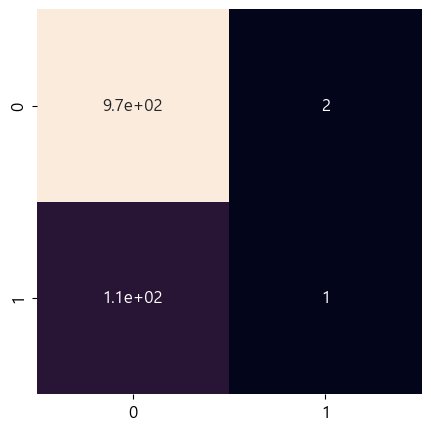

Accuracy:0.8994
Precision:0.3333
recall:0.0093
F1:0.0180
roc_auc:0.5036


In [342]:
x_tr, x_val, y_tr, y_val = train_test_split(new_df[x_col], new_df['y_train'], test_size=0.2, shuffle=True, random_state=20)

# 로지스틱 회귀 모델
from sklearn.linear_model import LogisticRegression
lr_model = LogisticRegression()
lr_model.fit(x_tr, y_tr)
y_val_pred = lr_model.predict(x_val)

# conFusion Matrix
from sklearn.metrics import confusion_matrix
sns.heatmap(confusion_matrix(y_val, y_val_pred), annot=True,  cbar=False, square=True)
# cbar를 통해 colorbar의 유무를 정해 줄 수 있고
# linewidths 각 cell마다 선을 넣어주고 굵기를 정할 수 있다.
# annot 각 cell의 값을 표기할 수 있다. 이때 fmt를 이용해 각 cell 값의 데이터 형태를 지정해주는 과정이 필요할 수 있다.
# vmin, vmax로 색으로 최대값, 최소값을 표현할 수 있다. ex) vmin = 200, vmax=500
plt.show()
# 평가지표
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score
print("Accuracy:%.4f" % accuracy_score(y_val, y_val_pred))
print("Precision:%.4f" % precision_score(y_val, y_val_pred))
print("recall:%.4f" % recall_score(y_val, y_val_pred))
print("F1:%.4f" % f1_score(y_val, y_val_pred))
print("roc_auc:%.4f" % roc_auc_score(y_val, y_val_pred))

In [343]:
y_tr = pd.DataFrame(y_tr,columns=['y_train'])
x_tr['y_train']= y_tr['y_train']

In [344]:
model = logit('y_train ~ x_tr[x_col]',data=x_tr)
fit = model.fit()
fit.summary()

Optimization terminated successfully.
         Current function value: 0.281879
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                y_train   No. Observations:                 4331
Model:                          Logit   Df Residuals:                     4325
Method:                           MLE   Df Model:                            5
Date:                Fri, 18 Aug 2023   Pseudo R-squ.:                 0.09700
Time:                        17:48:06   Log-Likelihood:                -1220.8
converged:                       True   LL-Null:                       -1352.0
Covariance Type:            nonrobust   LLR p-value:                 1.266e-54
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          3.5739      0.587      6.085      0.000       2.423       4.725
x_tr[x_col][0]    -0.6975      0.069    -10.041      0.000      -0.834      -0.561
x_tr[x_col][1]     0.6763      0.119      5.688      0.000       0.443       0.909
x_tr[x_col][2]    -0.3232      0.222     -1.458      0.145      -0.758       0.111
x_tr[x_col][3]    -0.6520      0.178     -3.662      0.000      -1.001      -0.303
x_tr[x_col][4]     0.6422      0.112      5.714      0.000       0.422       0.863
==================================================================================
"""

In [345]:
x_col

Index(['income', 'gen_2', 'health_state_5', 'disabled_2', 'work_state_2'], dtype='object')

In [346]:
new_df = new_df.drop(['health_state_5'],axis=1)
new_df.head()

,income,gen_2,disabled_2,work_state_2,y_train
0,6.006353,1,1,1,0
2,7.742836,0,1,0,0
8,7.737093,1,1,0,0
9,7.737093,1,1,1,0
13,8.692658,0,1,0,0


In [347]:
x_col = new_df.columns
x_col = x_col[:-1]
x_col

Index(['income', 'gen_2', 'disabled_2', 'work_state_2'], dtype='object')

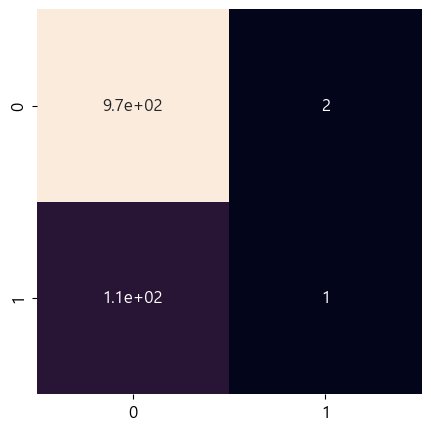

Accuracy:0.8994
Precision:0.3333
recall:0.0093
F1:0.0180
roc_auc:0.5036


In [348]:
x_tr, x_val, y_tr, y_val = train_test_split(new_df[x_col], new_df['y_train'], test_size=0.2, shuffle=True, random_state=20)

# 로지스틱 회귀 모델
from sklearn.linear_model import LogisticRegression
lr_model = LogisticRegression()
lr_model.fit(x_tr, y_tr)
y_val_pred = lr_model.predict(x_val)

# conFusion Matrix
from sklearn.metrics import confusion_matrix
sns.heatmap(confusion_matrix(y_val, y_val_pred), annot=True,  cbar=False, square=True)
# cbar를 통해 colorbar의 유무를 정해 줄 수 있고
# linewidths 각 cell마다 선을 넣어주고 굵기를 정할 수 있다.
# annot 각 cell의 값을 표기할 수 있다. 이때 fmt를 이용해 각 cell 값의 데이터 형태를 지정해주는 과정이 필요할 수 있다.
# vmin, vmax로 색으로 최대값, 최소값을 표현할 수 있다. ex) vmin = 200, vmax=500
plt.show()
# 평가지표
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score
print("Accuracy:%.4f" % accuracy_score(y_val, y_val_pred))
print("Precision:%.4f" % precision_score(y_val, y_val_pred))
print("recall:%.4f" % recall_score(y_val, y_val_pred))
print("F1:%.4f" % f1_score(y_val, y_val_pred))
print("roc_auc:%.4f" % roc_auc_score(y_val, y_val_pred))

In [349]:
y_tr = pd.DataFrame(y_tr,columns=['y_train'])
x_tr['y_train']= y_tr['y_train']

In [350]:
model = logit('y_train ~ x_tr[x_col]',data=x_tr)
fit = model.fit()
fit.summary()

Optimization terminated successfully.
         Current function value: 0.282143
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                y_train   No. Observations:                 4331
Model:                          Logit   Df Residuals:                     4326
Method:                           MLE   Df Model:                            4
Date:                Fri, 18 Aug 2023   Pseudo R-squ.:                 0.09616
Time:                        17:48:06   Log-Likelihood:                -1222.0
converged:                       True   LL-Null:                       -1352.0
Covariance Type:            nonrobust   LLR p-value:                 4.565e-55
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          3.6580      0.586      6.244      0.000       2.510       4.806
x_tr[x_col][0]    -0.7091      0.069    -10.242      0.000      -0.845      -0.573
x_tr[x_col][1]     0.6860      0.119      5.778      0.000       0.453       0.919
x_tr[x_col][2]    -0.6726      0.178     -3.785      0.000      -1.021      -0.324
x_tr[x_col][3]     0.6409      0.112      5.703      0.000       0.421       0.861
==================================================================================
"""

In [351]:
pd.DataFrame({'컬럼': column, 'VIF': variance_inflation_factor(model.exog, i)} 
             for i, column in enumerate(model.exog_names)
             if column != 'Intercept')  # 절편의 VIF는 구하지 않는다.

,컬럼,VIF
0,x_tr[x_col][0],1.072847
1,x_tr[x_col][1],1.049409
2,x_tr[x_col][2],1.039869
3,x_tr[x_col][3],1.098321


In [352]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(random_state=20)
from sklearn.model_selection import cross_val_score

auc_scores = cross_val_score(lr_model, x_tr, x_tr['y_train'], cv=5, scoring='roc_auc')
print("개별 Fold의 AUC 점수 :", np.round(auc_scores, 4))
print("평균 AUC 점수:", np.round(np.mean(auc_scores), 4))

개별 Fold의 AUC 점수 : [1. 1. 1. 1. 1.]
평균 AUC 점수: 1.0


In [353]:
def plot_importance(model, features):
    importances = model.feature_importances_
    indices = np.argsort(importances)
    feature_names = [features[i] for i in indices]
    feature_imp = importances[indices]

    plt.figure(figsize=(10,12))
    plt.title("Feature impotance")
    plt.barh(range(len(indices)), feature_imp, align='center')
    plt.yticks(range(len(indices)), feature_names)
    plt.xlabel("Relative Importance")

    print("피처:", list(reversed(feature_names)))
    print("중요도:", list(reversed(feature_imp)))

    return list(reversed(feature_names)), list(reversed(feature_imp))

In [354]:
rf_model.fit(x_tr.iloc[:,:-1], x_tr['y_train'])

RandomForestClassifier(random_state=20)

In [355]:
selected_features = list(x_tr.columns)

In [356]:
selected_features = selected_features[:-1]

피처: ['income', 'work_state_2', 'gen_2', 'disabled_2']
중요도: [0.9484380711750253, 0.02267717800871048, 0.015050679906019156, 0.013834070910245059]


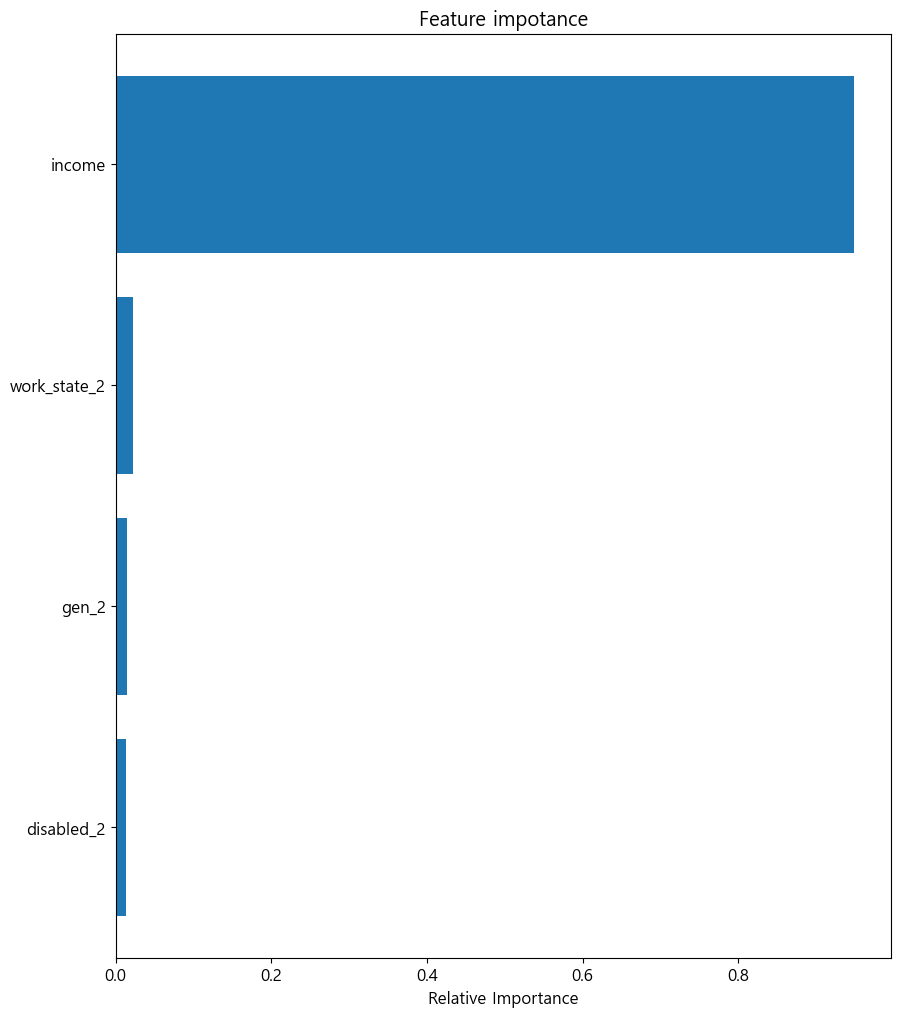

In [357]:
imp_features, imp_scores = plot_importance(rf_model, selected_features)

In [358]:
new_df.head()

,income,gen_2,disabled_2,work_state_2,y_train
0,6.006353,1,1,1,0
2,7.742836,0,1,0,0
8,7.737093,1,1,0,0
9,7.737093,1,1,1,0
13,8.692658,0,1,0,0


In [359]:
# plt.figure(figsize=(15, 7))
# sb.regplot(data=new_df, x='disabled_2', y='y_train')
# sb.regplot(data=new_df, x='disabled_2', y=ols_result.fit.fittedvalues, color='red')
# plt.grid()
# plt.plot()
# plt.show()

In [360]:
# plt.figure(figsize=(15, 7))
# sb.regplot(data=new_df, x='income', y='y_train')
# sb.regplot(data=new_df, x='income', y=ols_result.fit.fittedvalues, color='red')
# plt.grid()
# plt.plot()
# plt.show()

In [361]:
from sklearn.decomposition import PCA
model = PCA(n_components=5)
fit = model.fit_transform(new_df)
fit

array([[ 2.68861752, -0.13113503,  0.11332521, -0.44249987, -0.14455041],
       [ 0.67029019,  0.7865193 ,  0.17894156, -0.13696237, -0.10006286],
       [ 0.78389593, -0.08685822,  0.64574879, -0.17913335, -0.03186427],
       ...,
       [-0.56536246,  0.50036674, -0.06776281, -0.0094032 , -0.04818739],
       [-0.39882835,  0.53893272, -0.03451342, -0.02659488, -0.05517887],
       [-0.03174183, -0.7611161 , -0.42980845, -0.16167113, -0.03034363]])

In [362]:
pca_df = DataFrame(fit)
pca_df

,0,1,2,3,4
0,2.688618,-0.131135,0.113325,-0.442500,-0.144550
1,0.670290,0.786519,0.178942,-0.136962,-0.100063
2,0.783896,-0.086858,0.645749,-0.179133,-0.031864
3,1.042838,-0.512265,-0.215263,-0.272602,-0.075457
4,-0.232906,0.577357,-0.001386,-0.043723,-0.062145
...,...,...,...,...,...
5409,-0.576101,0.497880,-0.069907,-0.008295,-0.047737
5410,-0.209014,-0.802169,-0.465202,-0.143371,-0.022901
5411,-0.565362,0.500367,-0.067763,-0.009403,-0.048187
5412,-0.398828,0.538933,-0.034513,-0.026595,-0.055179


In [363]:
model = pca(n_components=len(new_df.columns))
# 표준화 결과를 활용하여 주성분 분석 수행
fit = model.fit_transform(new_df)
fit

[pca] >Extracting column labels from dataframe.
[pca] >Extracting row labels from dataframe.
[pca] >The PCA reduction is performed on the [5] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[5]
[pca] >Multiple test correction applied for Hotelling T2 test: [fdr_bh]
[pca] >Outlier detection using SPE/DmodX with n_std=[3]


{'loadings':        income     gen_2  disabled_2  work_state_2   y_train
 PC1 -0.950911  0.108145   -0.061696      0.258942  0.114958
 PC2 -0.220212 -0.874642   -0.040636     -0.425407 -0.062334
 PC3 -0.189854  0.465717    0.068321     -0.861012 -0.032464
 PC4  0.098165 -0.041607   -0.157131     -0.093469  0.977346
 PC5  0.039921  0.068428   -0.982438     -0.043593 -0.163215,
 'PC':             PC1       PC2       PC3       PC4       PC5
 0      2.688618 -0.131135  0.113325 -0.442500 -0.144550
 2      0.670290  0.786519  0.178942 -0.136962 -0.100063
 8      0.783896 -0.086858  0.645749 -0.179133 -0.031864
 9      1.042838 -0.512265 -0.215263 -0.272602 -0.075457
 13    -0.232906  0.577357 -0.001386 -0.043723 -0.062145
 ...         ...       ...       ...       ...       ...
 13469 -0.576101  0.497880 -0.069907 -0.008295 -0.047737
 13470 -0.209014 -0.802169 -0.465202 -0.143371 -0.022901
 13471 -0.565362  0.500367 -0.067763 -0.009403 -0.048187
 13472 -0.398828  0.538933 -0.034513 -0.02659

In [364]:
topfit = fit['topfeat']
topfit

,PC,feature,loading,type
0,PC1,income,-0.950911,best
1,PC2,gen_2,-0.874642,best
2,PC3,work_state_2,-0.861012,best
3,PC4,y_train,0.977346,best
4,PC5,disabled_2,-0.982438,best


In [365]:
df = pd.read_excel("빚추가마지막.xlsx")
df.head()

,Unnamed: 0,gen,age,religion,edu,sm_year,sm_state,sm_day,dr_mean_year,dr_6cup,...,preg_experience,health_state,disabled,work_state,work_code,region,income,y_total,debt,y_train
0,0,female,78,yes,중졸,NaN,no,NaN,전혀마시지않음,NaN,...,없다,2,abled,nowork,NaN,city,405.0,20,10350.0,0
1,1,male,75,no,초졸이하,NaN,no,NaN,전혀마시지않음,NaN,...,남성,1,abled,work,942.0,city,2788.0,29,0.0,1
2,2,male,81,yes,대졸이상,NaN,no,NaN,전혀마시지않음,NaN,...,남성,4,abled,work,762.0,city,2304.0,18,21220.0,0
3,3,male,61,yes,대졸이상,NaN,no,NaN,전혀마시지않음,NaN,...,남성,4,abled,work,855.0,city,5231.0,20,0.0,0
4,4,female,60,yes,고졸,NaN,no,NaN,전혀마시지않음,NaN,...,없다,4,abled,work,399.0,city,5231.0,21,0.0,0


In [366]:
df_c = new_df.drop(['y_train'], axis=1)
df_c

,income,gen_2,disabled_2,work_state_2
0,6.006353,1,1,1
2,7.742836,0,1,0
8,7.737093,1,1,0
9,7.737093,1,1,1
13,8.692658,0,1,0
...,...,...,...,...
13469,9.053570,0,1,0
13470,9.053570,1,1,1
13471,9.042277,0,1,0
13472,8.867146,0,1,0


In [367]:
from sklearn.model_selection import GridSearchCV
from sklearn import svm 
from sklearn.linear_model import LogisticRegression

In [368]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(df_c, new_df['y_train'], test_size=0.2, random_state=42)

In [369]:
cat_params = {
                'verbose' : 100,
                'random_state': 113,
               # 'use_best_model' : True,
             }

In [370]:
from sklearn import svm
# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import RidgeClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier


# Classifiers
names = [
    "Logistic Regression",
    "KNN Classifier",
    "Decision Tree",
    "Linear SVM",
    "Random Forest",
    "SGD Classifier",
    "Ridge Classifier",
    "XGBoost",
    "AdaBoost",
]

models = [
    LogisticRegression(max_iter = 1000),
    KNeighborsClassifier(n_neighbors = 149, n_jobs = -1),
    DecisionTreeClassifier(),
    svm.SVC(kernel = 'linear'),
    RandomForestClassifier(n_estimators = 100),
    SGDClassifier(loss = 'hinge'),
    RidgeClassifier(),
    XGBClassifier(),
    AdaBoostClassifier(),
]

In [371]:
import time
# Function to return summary of baseline models
def score(X_train, y_train, X_val, y_val, names = names, models = models):
    score_df, score_train, score_val = pd.DataFrame(), [], []
    x = time.time()
    for model in models:
        model.fit(X_train, y_train)
        y_train_pred, y_val_pred = model.predict(X_train), model.predict(X_val)
        score_train.append(accuracy_score(y_train, y_train_pred))
        score_val.append(accuracy_score(y_val, y_val_pred))
    
    score_df["Classifier"], score_df["Training accuracy"], score_df["Validation accuracy"] = names, score_train, score_val
    score_df.sort_values(by = 'Validation accuracy', ascending = False, inplace = True)
    return score_df

In [372]:
score(X_train, y_train, X_test, y_test, names = names, models = models)

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, a

,Classifier,Training accuracy,Validation accuracy
8,AdaBoost,0.906950,0.904894
0,Logistic Regression,0.904410,0.903970
1,KNN Classifier,0.904872,0.903970
3,Linear SVM,0.904872,0.903970
5,SGD Classifier,0.903948,0.903970
6,Ridge Classifier,0.904641,0.903970
7,XGBoost,0.924729,0.902124
2,Decision Tree,0.987532,0.854109
4,Random Forest,0.987532,0.850416


In [373]:
clf = RidgeClassifier(random_state=113)

clf.fit(X_train,y_train)

RidgeClassifier(random_state=113)

In [374]:
from sklearn.metrics import accuracy_score

y_val_pred = clf.predict(X_test)

print(accuracy_score(y_test, y_val_pred))

0.9039704524469068


In [375]:
from sklearn.preprocessing import PolynomialFeatures
pf = PolynomialFeatures(degree=2)
x_train_poly = pf.fit_transform(X_train)
print("원본 학습 데이터 셋:", X_train.shape) 
print("2차 다항식 변환 데이터 셋:", x_train_poly.shape)

원본 학습 데이터 셋: (4331, 4)
2차 다항식 변환 데이터 셋: (4331, 15)


In [376]:
from sklearn.model_selection import cross_val_score
lr = LinearRegression()
mse_score = -1*cross_val_score(lr, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
print("개별 Fold의 MSE:", np.round(mse_score, 4))
print("평균 MSE:%4f" % np.mean(mse_score))

개별 Fold의 MSE: [0.0826 0.0767 0.077  0.0781 0.0881]
평균 MSE:0.080491


In [377]:
# 2차 다항식 변환 데이터셋으로 선형 회귀 모델 모형 학습
from sklearn.metrics import mean_squared_error
lr = LinearRegression()
lr.fit(x_train_poly, y_train) # y_train은 실제 결과값

# 테스트 데이터에 대한 예측 밒 평가
y_train_pred = lr.predict(x_train_poly)
train_mse = mean_squared_error(y_train, y_train_pred)
print("Train MSE:%3f" % train_mse)

x_test_poly = pf.fit_transform(X_test) # 학습한 예측결과랑 test값의 예측 결과 파악
y_test_pred = lr.predict(x_test_poly)
test_mse = mean_squared_error(y_test, y_test_pred)
print("Test MSE:%3f" % test_mse)

Train MSE:0.079229
Test MSE:0.080858


In [378]:
print(lr.predict(x_train_poly))

[0.02595659 0.03683339 0.02031972 ... 0.20901344 0.09287539 0.02108152]


In [379]:
pf = PolynomialFeatures(degree=15)
x_train_poly = pf.fit_transform(X_train)

lr = LinearRegression()
lr.fit(x_train_poly, y_train)

# 테스트 데이터에 대한 예측 및 평가
y_train_pred = lr.predict(x_train_poly)
train_mse = mean_squared_error(y_train, y_train_pred)
print("Train MSE: %.3f" % train_mse)

x_test_poly = pf.fit_transform(X_test)
y_test_pred = lr.predict(x_test_poly)
test_mse = mean_squared_error(y_test, y_test_pred)
print("Test MSE:%.4f" % test_mse)

Train MSE: 0.077
Test MSE:0.4842


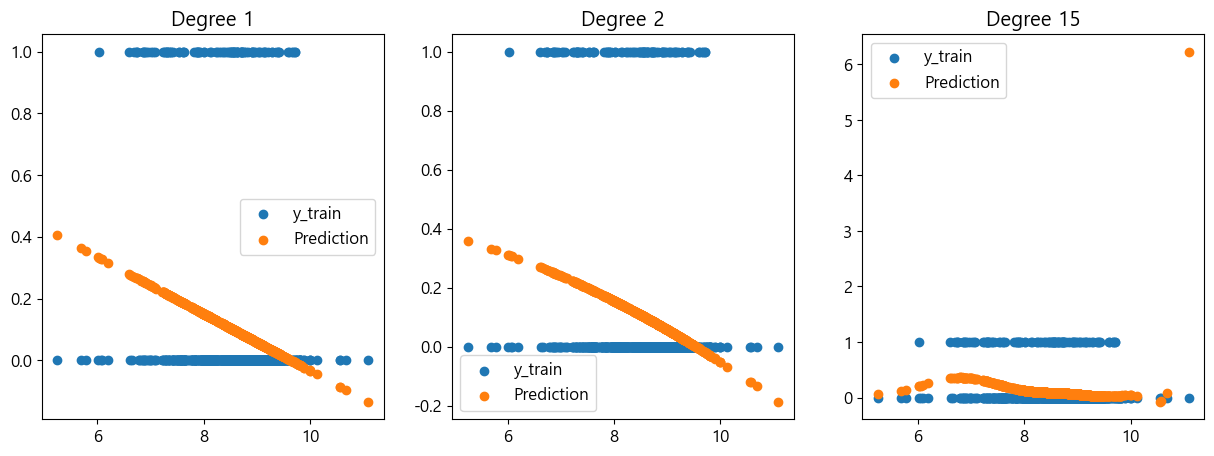

In [380]:
plt.figure(figsize=(15,5))
for n, deg in enumerate([1, 2, 15]):
    axl = plt.subplot(1,3, n+1)
    # plt.axis('off')
    # degree별 다항 회귀 모형 적용
    pf = PolynomialFeatures(degree=deg)
    x_train_poly = pf.fit_transform(X_train.loc[:,['income']]) # 전채 행 선택후 열의 LSTAT선택 즉, RM제외
    x_test_poly = pf.fit_transform(X_test.loc[:, ['income']])
    lr = LinearRegression()
    lr.fit(x_train_poly, y_train)
    y_test_pred = lr.predict(x_test_poly)
    # 실제값 분포
    plt.scatter(X_test.loc[:,['income']], y_test, label='y_train')
    # 예측값 분포
    plt.scatter(X_test.loc[:,['income']], y_test_pred, label='Prediction')
    # 제목 표시
    plt.title("Degree %d" % deg)
    # 범례 표시
    plt.legend()
plt.show()

In [381]:
# Ridge(L2 규제)
from sklearn.linear_model import Ridge
rdg = Ridge(alpha=2.5) # 알파값으로 강도를 조정
rdg.fit(x_train_poly, y_train)

y_train_pred = rdg.predict(x_train_poly)
train_mse = mean_squared_error(y_train, y_train_pred)
print("Train MSE:%.4f" % train_mse)
y_test_pred = rdg.predict(x_test_poly)
test_mse = mean_squared_error(y_test, y_test_pred)
print("Test MSE:%.4f" % test_mse)

Train MSE:0.0809
Test MSE:0.1124


c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=9.23247e-34): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T


In [382]:
# Lasso(L1 규제)
from sklearn.linear_model import Lasso
las = Lasso(alpha=0.05)
las.fit(x_train_poly, y_train)

y_train_pred = las.predict(x_train_poly)
train_mse = mean_squared_error(y_train, y_train_pred)
print("Train MSE:%.4f" % train_mse)
y_test_pred = las.predict(x_test_poly)
test_mse = mean_squared_error(y_test, y_test_pred)
print("Test MSE:%.4f" % test_mse)

Train MSE:0.0815
Test MSE:0.0828


c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.764e+02, tolerance: 3.728e-02
  model = cd_fast.enet_coordinate_descent(


In [383]:
# ElasticNet(L2/L1 규제)
from sklearn.linear_model import ElasticNet
ela = ElasticNet(alpha=0.1, l1_ratio=0.7)
ela.fit(x_train_poly, y_train)

y_train_pred = ela.predict(x_train_poly)
train_mse = mean_squared_error(y_train, y_train_pred)
print("train MSE:%.4f" % train_mse)
y_test_pred = ela.predict(x_test_poly)
test_mse = mean_squared_error(y_test, y_test_pred)
print("test_mse:%.4f" % test_mse)
y_test_pred

train MSE:0.0815
test_mse:0.0828


c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.765e+02, tolerance: 3.728e-02
  model = cd_fast.enet_coordinate_descent(


array([0.04996101, 0.08221682, 0.04919868, ..., 0.23729252, 0.20450615,
       0.02793938])

In [384]:
# 의사결정나무
from sklearn.tree import DecisionTreeRegressor
dtr = DecisionTreeRegressor(max_depth=3, random_state=12)
dtr.fit(X_train, y_train)

y_train_pred = dtr.predict(X_train)
train_mse = mean_squared_error(y_train, y_train_pred)
print("Train MSE:%.4f" % train_mse)

y_test_pred = dtr.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_pred)
print("Test MSE:%.4f" % test_mse)
y_test_pred

Train MSE:0.0792
Test MSE:0.0815


array([0.05865658, 0.07718405, 0.05865658, ..., 0.19354839, 0.19354839,
       0.05865658])

In [385]:
# 랜덤 포레스트
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(max_depth=3, random_state=12)
rfr.fit(X_train, y_train)

y_train_pred = rfr.predict(X_train)
train_mse = mean_squared_error(y_train, y_train_pred)
print("Train MSE:%.4f" % train_mse)

y_test_pred = rfr.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_pred)
print("Test MSE:%.4f" % test_mse)
y_test_pred

Train MSE:0.0782
Test MSE:0.0796


array([0.0582061 , 0.06876143, 0.0534511 , ..., 0.30190672, 0.2608147 ,
       0.03889562])

In [386]:
import numpy as np
from scipy import stats

# 예제 데이터 생성
data = new_df['y_train']

# 신뢰 수준 설정 (95%)
confidence_level = 0.95

# 데이터의 평균과 표준편차 계산
mean = np.mean(data)
std_dev = np.std(data, ddof=1)  # ddof=1 for sample standard deviation

# 신뢰구간 계산
confidence_interval = stats.t.interval(confidence_level, len(data) - 1, loc=mean, scale=std_dev/np.sqrt(len(data)))

print("Confidence Interval:", confidence_interval)

Confidence Interval: (0.08748421911824425, 0.10313269998038893)


In [387]:
new_df['y_train'].describe()
new_df['y_train'].value_counts()

y_train
0    4898
1     516
Name: count, dtype: int64

In [388]:
new_df['y_train']

0        0
2        0
8        0
9        0
13       0
        ..
13469    0
13470    0
13471    0
13472    0
13473    0
Name: y_train, Length: 5414, dtype: int64

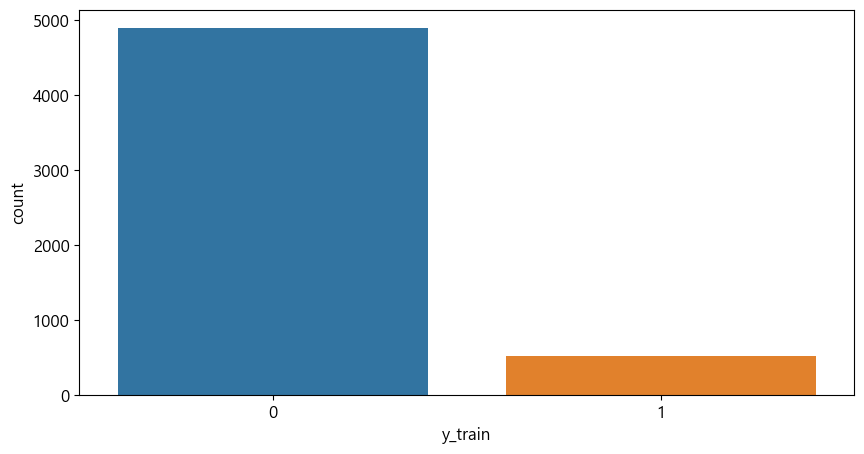

In [389]:
sns.countplot(x='y_train', data=new_df)
plt.show()

In [390]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5414 entries, 0 to 13473
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   income        5414 non-null   float64
 1   gen_2         5414 non-null   int32  
 2   disabled_2    5414 non-null   int32  
 3   work_state_2  5414 non-null   int32  
 4   y_train       5414 non-null   int64  
dtypes: float64(1), int32(3), int64(1)
memory usage: 190.3 KB


In [391]:
class OlsResult:
    def __init__(self):
        self._model = None
        self._fit = None
        self._summary = None
        self._table = None
        self._result = None
        self._goodness = None
        self._varstr = None

def myOls(data, y, x):
    """
    회귀분석을 수행한다.

    Parameters
    -------
    - data : 데이터 프레임
    - y: 종속변수 이름
    - x: 독립변수의 이름들(리스트)
    """

    # 독립변수의 이름이 리스트가 아니라면 리스트로 변환
    if type(x) != list:
        x = [x]

    # 종속변수~독립변수1+독립변수2+독립변수3+... 형태의 식을 생성
    expr = "%s~%s" % (y, "+".join(x))

    # 회귀모델 생성
    model = ols(expr, data=data)
    # 분석 수행
    fit = model.fit()

    # 파이썬 분석결과를 변수에 저장한다.
    summary = fit.summary()

    # 첫 번째, 세 번째 표의 내용을 딕셔너리로 분해
    my = {}

    for k in range(0, 3, 2):
        items = summary.tables[k].data
        # print(items)

        for item in items:
            # print(item)
            n = len(item)

            for i in range(0, n, 2):
                key = item[i].strip()[:-1]
                value = item[i+1].strip()

                if key and value:
                    my[key] = value

    # 두 번째 표의 내용을 딕셔너리로 분해하여 my에 추가
    my['variables'] = []
    name_list = list(data.columns)
    #print(name_list)

    for i, v in enumerate(summary.tables[1].data):
        if i == 0:
            continue

        # 변수의 이름
        name = v[0].strip()

        vif = 0

        # Intercept는 제외
        if name in name_list:
            # 변수의 이름 목록에서 현재 변수가 몇 번째 항목인지 찾기 
            j = name_list.index(name)
            vif = variance_inflation_factor(data, j)

        my['variables'].append({
            "name": name,
            "coef": v[1].strip(),
            "std err": v[2].strip(),
            "t": v[3].strip(),
            "P-value": v[4].strip(),
            "Beta": 0,
            "VIF": vif,
        })

    # 결과표를 데이터프레임으로 구성
    mylist = []
    yname_list = []
    xname_list = []

    for i in my['variables']:
        if i['name'] == 'Intercept':
            continue

        yname_list.append(y)
        xname_list.append(i['name'])

        item = {
            "B": i['coef'],
            "표준오차": i['std err'],
            "β": i['Beta'],
            "t": "%s*" % i['t'],
            "유의확률": i['P-value'],
            "VIF": i["VIF"]
        }

        mylist.append(item)

    table = DataFrame(mylist,
                   index=MultiIndex.from_arrays([yname_list, xname_list], names=['종속변수', '독립변수']))
    
    # 분석결과
    result = "𝑅(%s), 𝑅^2(%s), 𝐹(%s), 유의확률(%s), Durbin-Watson(%s)" % (my['R-squared'], my['Adj. R-squared'], my['F-statistic'], my['Prob (F-statistic)'], my['Durbin-Watson'])

    # 모형 적합도 보고
    goodness = "%s에 대하여 %s로 예측하는 회귀분석을 실시한 결과, 이 회귀모형은 통계적으로 %s(F(%s,%s) = %s, p < 0.05)." % (y, ",".join(x), "유의하다" if float(my['Prob (F-statistic)']) < 0.05 else "유의하지 않다", my['Df Model'], my['Df Residuals'], my['F-statistic'])

    # 독립변수 보고
    varstr = []

    for i, v in enumerate(my['variables']):
        if i == 0:
            continue
        
        s = "%s의 회귀계수는 %s(p%s0.05)로, %s에 대하여 %s."
        k = s % (v['name'], v['coef'], "<" if float(v['P-value']) < 0.05 else '>', y, '유의미한 예측변인인 것으로 나타났다' if float(v['P-value']) < 0.05 else '유의하지 않은 예측변인인 것으로 나타났다')

        varstr.append(k)

    ols_result = OlsResult()
    ols_result.model = model
    ols_result.fit = fit
    ols_result.summary = summary
    ols_result.table = table
    ols_result.result = result
    ols_result.goodness = goodness
    ols_result.varstr = varstr

    return ols_result

In [392]:
ols = myOls(new_df, x='income', y='y_train')

In [393]:
y = ols.fit.predict(new_df['income'])
y

0        0.330561
2        0.173349
8        0.173869
9        0.173869
13       0.087358
           ...   
13469    0.054682
13470    0.054682
13471    0.055705
13472    0.071560
13473    0.071560
Length: 5414, dtype: float64

In [394]:
y = ols.fit.fittedvalues
y

0        0.330561
2        0.173349
8        0.173869
9        0.173869
13       0.087358
           ...   
13469    0.054682
13470    0.054682
13471    0.055705
13472    0.071560
13473    0.071560
Length: 5414, dtype: float64

In [395]:
residual = ols.fit.resid
residual

0       -0.330561
2       -0.173349
8       -0.173869
9       -0.173869
13      -0.087358
           ...   
13469   -0.054682
13470   -0.054682
13471   -0.055705
13472   -0.071560
13473   -0.071560
Length: 5414, dtype: float64

In [396]:
ols.fit.model.exog

array([[1.        , 6.00635316],
       [1.        , 7.74283596],
       [1.        , 7.73709281],
       ...,
       [1.        , 9.04227669],
       [1.        , 8.86714559],
       [1.        , 8.86714559]])

In [397]:
new_df['예측값'] = y
new_df['잔차'] = residual
new_df.head()

,income,gen_2,disabled_2,work_state_2,y_train,예측값,잔차
0,6.006353,1,1,1,0,0.330561,-0.330561
2,7.742836,0,1,0,0,0.173349,-0.173349
8,7.737093,1,1,0,0,0.173869,-0.173869
9,7.737093,1,1,1,0,0.173869,-0.173869
13,8.692658,0,1,0,0,0.087358,-0.087358


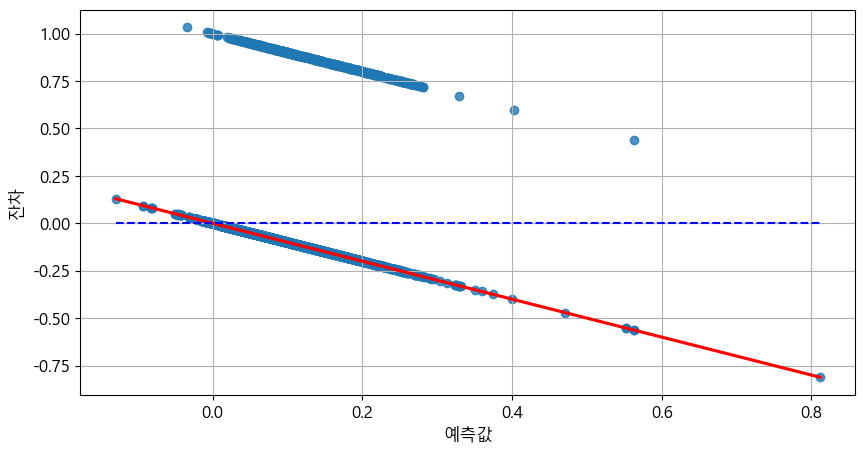

In [398]:
xmin = new_df['예측값'].min()
xmax = new_df['예측값'].max()
xrange = [xmin, xmax]
yrange = [0, 0]

plt.figure()
sb.regplot(data=new_df, x='예측값', y='잔차', lowess=True, line_kws={'color': 'red'})
sb.lineplot(x=xrange, y=yrange, color='blue', linestyle='--')
plt.grid()
plt.show()
plt.close()

In [399]:
new_df['zscore'] = stats.zscore(new_df['예측값'])
new_df.head()

,income,gen_2,disabled_2,work_state_2,y_train,예측값,잔차,zscore
0,6.006353,1,1,1,0,0.330561,-0.330561,3.754265
2,7.742836,0,1,0,0,0.173349,-0.173349,1.245410
8,7.737093,1,1,0,0,0.173869,-0.173869,1.253707
9,7.737093,1,1,1,0,0.173869,-0.173869,1.253707
13,8.692658,0,1,0,0,0.087358,-0.087358,-0.126885


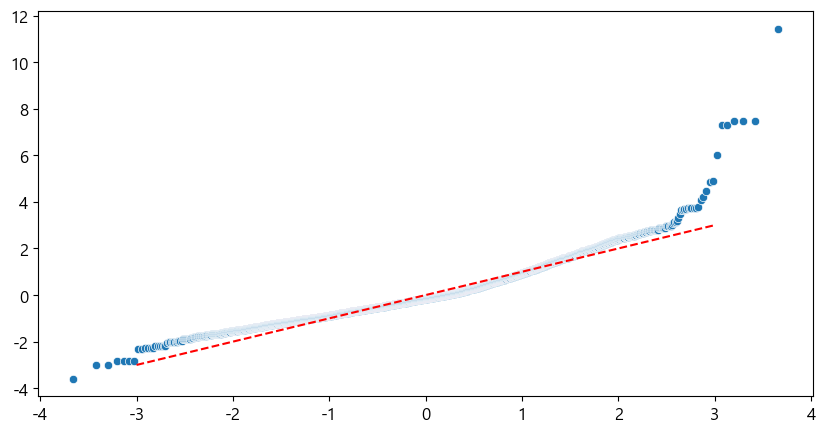

In [400]:
(x,y), _ = stats.probplot(new_df['zscore'])
sb.scatterplot(x=x, y=y)
sb.lineplot(x=[-3, 3], y=[-3, 3], color='red', linestyle='--')
plt.show()
plt.close()